**Spark notebook**

This notebook will only work in a Jupyter session running on `mathmadslinux2p`.

You can start your own Jupyter session on `mathmadslinux2p` and open this notebook in Chrome on the MADS Windows server by

1. Login to the MADS Windows server using https://mathportal.canterbury.ac.nz/.
2. Download or copy this notebook to your home directory.
3. Open powershell and run `ssh mathmadslinux2p`.
4. Run `start_pyspark_notebook` or `/opt/anaconda3/bin/jupyter-notebook --ip 132.181.129.68 --port $((8000 + $((RANDOM % 999))))`.
5. Copy / paste the url provided in the shell window into Chrome on the MADS Windows server.
6. Open the notebook from the Jupyter root directory (which is your home directory).
7. Run `start_spark()` to start a spark session in the notebook.
8. Run `stop_spark()` before closing the notebook or kill your spark application by hand using the link in the Spark UI.

In [673]:
# Run this cell to import pyspark and to define start_spark() and stop_spark()

import findspark

findspark.init()

import getpass
import pandas
import pyspark
import random
import re

from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession


# Functions used below

def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))


# Print function docstrings

help(start_spark)
help(stop_spark)
help(display_spark)
help(show_as_html)

Help on function start_spark in module __main__:

start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1)
    Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)

Help on function stop_spark in module __main__:

stop_spark()
    Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).

Help on function display_spark in module __main__:

display_spark()
    Display the status of the active Spark session if one is currently running.

Help on function show_as_html in module __main__:

show_as_html(df, n=20)
    Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n 

In [674]:
# Run this cell to start a spark session in this notebook

start_spark(executor_instances=4, executor_cores=2, worker_memory=4, master_memory=1)

spark.dynamicAllocation.enabled,false
spark.executor.instances,4
spark.driver.extraJavaOptions,-Dderby.system.home=/tmp/abh89/spark/
spark.ui.port,4617
spark.app.name,abh89 (jupyter)
spark.executor.memory,4g
spark.master,spark://masternode2:7077
spark.executor.id,driver
spark.app.startTime,1667339546919
spark.sql.warehouse.dir,file:/users/home/abh89/spark/spark-warehouse
spark.driver.memory,1g


In [675]:
# Write your imports and code here or insert cells below

from pyspark.sql import Row, DataFrame, Window, functions as F
from pyspark.sql.types import *

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import numpy as np
import pandas as pd

In [676]:
# Other imports to be used locally

import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd

%matplotlib notebook

np.set_printoptions(edgeitems=5, threshold=100, precision=4)


def expand(x, s=0.05, d=0):
    """Expand a two element array about its center point by a relative scale or a fixed offset.
    Args:
        x (list|np.array): two element array
        s (float): relative scale to expand array based on its width x[1] - x[0]
        d (float): fixed offset to expand array
    Returns:
        x (np.array): expanded two element array
    """
    x = np.array(x)
    d = d + s * (x[1] - x[0])
    return x + np.array([-d, d])


In [677]:
# Helper functions

def print_class_balance(data, name):
    """
    """

    total = data.count()
    counts = data.groupBy("label").count().toPandas()
    counts["ratio"] = counts["count"] / total

    print(f'dataset: {name}')
    print(f'total:   {total}')
    print(f'counts:')
    print(counts)
    print(f'')

    
def with_custom_prediction(pred, threshold, probabilityCol="probability", customPredictionCol="customPrediction"):
    """
    """

    apply_custom_threshold_udf = F.udf(lambda x: int(x[1] > threshold), IntegerType())

    return pred.withColumn(customPredictionCol, apply_custom_threshold_udf(F.col(probabilityCol)))


def print_metrics(pred, threshold=0.5, labelCol="label", predictionCol="prediction", rawPredictionCol="rawPrediction", probabilityCol="probability"):
    """
    """

    if threshold != 0.5:

        predictionCol = "customPrediction"
        pred = with_custom_prediction(pred, threshold, probabilityCol=probabilityCol, customPredictionCol=predictionCol)

    total = pred.count()

    nP_actual = pred.filter((F.col(labelCol) == 1)).count()
    nN_actual = pred.filter((F.col(labelCol) == 0)).count()

    nP = pred.filter((F.col(predictionCol) == 1)).count()
    nN = pred.filter((F.col(predictionCol) == 0)).count()
    TP = pred.filter((F.col(predictionCol) == 1) & (F.col(labelCol) == 1)).count()
    FP = pred.filter((F.col(predictionCol) == 1) & (F.col(labelCol) == 0)).count()
    FN = pred.filter((F.col(predictionCol) == 0) & (F.col(labelCol) == 1)).count()
    TN = pred.filter((F.col(predictionCol) == 0) & (F.col(labelCol) == 0)).count()

    if TP + FP > 0:
        precision = TP / (TP + FP)
    else:
        precision = 0
        
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / total

    binary_evaluator = BinaryClassificationEvaluator(rawPredictionCol=rawPredictionCol, labelCol=labelCol, metricName='areaUnderROC')
    auroc = binary_evaluator.evaluate(pred)

    print(f'metrics for custom threshold')
    print(f'')
    print(f'threshold: {threshold}')
    print(f'')
    print(f'total:     {total}')
    print(f'')
    print(f'nP actual: {nP_actual}')
    print(f'nN actual: {nN_actual}')
    print(f'')
    print(f'nP:        {nP}')
    print(f'nN:        {nN}')
    print(f'')
    print(f'TP         {TP}')
    print(f'FP         {FP}')
    print(f'FN         {FN}')
    print(f'TN         {TN}')
    print(f'')
    print(f'precision: {precision:.8f}')
    print(f'recall:    {recall:.8f}')
    print(f'accuracy:  {accuracy:.8f}')
    print(f'')
    print(f'auroc:     {auroc:.8f}')
    print(f'')

In [678]:
! hdfs dfs -ls -h /data/msd

Found 4 items
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 /data/msd/audio
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 /data/msd/genre
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:28 /data/msd/main
drwxr-xr-x   - jsw93 supergroup          0 2021-09-29 10:35 /data/msd/tasteprofile


In [679]:
!hdfs dfs -du -h /data/msd/audio

103.0 K  824.3 K  /data/msd/audio/attributes
12.2 G   97.8 G   /data/msd/audio/features
40.3 M   322.1 M  /data/msd/audio/statistics


In [1024]:
# Metadata from MSD
metadata = spark.read.csv("hdfs:///data/msd/main/summary/metadata.csv.gz", header = True)
metadata.show(10)

+----------------+-----------------+-------------------+-------------------+------------------+---------------+--------------------+----------------+--------------------+--------------------+---------------+-----+----------------+-------------------+--------------------+------------------+------------------+------------------+--------------------+----------------+
|analyzer_version|artist_7digitalid| artist_familiarity|  artist_hotttnesss|         artist_id|artist_latitude|     artist_location|artist_longitude|         artist_mbid|         artist_name|artist_playmeid|genre|idx_artist_terms|idx_similar_artists|             release|release_7digitalid|   song_hotttnesss|           song_id|               title|track_7digitalid|
+----------------+-----------------+-------------------+-------------------+------------------+---------------+--------------------+----------------+--------------------+--------------------+---------------+-----+----------------+-------------------+----------------

In [681]:
metadata.printSchema()

root
 |-- analyzer_version: string (nullable = true)
 |-- artist_7digitalid: string (nullable = true)
 |-- artist_familiarity: string (nullable = true)
 |-- artist_hotttnesss: string (nullable = true)
 |-- artist_id: string (nullable = true)
 |-- artist_latitude: string (nullable = true)
 |-- artist_location: string (nullable = true)
 |-- artist_longitude: string (nullable = true)
 |-- artist_mbid: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- artist_playmeid: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- idx_artist_terms: string (nullable = true)
 |-- idx_similar_artists: string (nullable = true)
 |-- release: string (nullable = true)
 |-- release_7digitalid: string (nullable = true)
 |-- song_hotttnesss: string (nullable = true)
 |-- song_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- track_7digitalid: string (nullable = true)



In [682]:
metadata.select("song_id").distinct().count()

998963

In [683]:
analysis = spark.read.csv("hdfs:///data/msd/main/summary/analysis.csv.gz", header = True)
analysis.show(10)

+--------------------+--------------------+------------+---------+--------------+------+-------------------+--------------+--------------------+---------------+-----------------------+------------------+-----------------------+-------------------------+------------------------------+---------------------------+--------------------+------------------+-------------------+---------------------+----------------+---+--------------+--------+----+---------------+-----------------+-------+--------------+-------------------------+------------------+
|analysis_sample_rate|           audio_md5|danceability| duration|end_of_fade_in|energy|idx_bars_confidence|idx_bars_start|idx_beats_confidence|idx_beats_start|idx_sections_confidence|idx_sections_start|idx_segments_confidence|idx_segments_loudness_max|idx_segments_loudness_max_time|idx_segments_loudness_start|idx_segments_pitches|idx_segments_start|idx_segments_timbre|idx_tatums_confidence|idx_tatums_start|key|key_confidence|loudness|mode|mode_conf

In [684]:
analysis.printSchema()

root
 |-- analysis_sample_rate: string (nullable = true)
 |-- audio_md5: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- end_of_fade_in: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- idx_bars_confidence: string (nullable = true)
 |-- idx_bars_start: string (nullable = true)
 |-- idx_beats_confidence: string (nullable = true)
 |-- idx_beats_start: string (nullable = true)
 |-- idx_sections_confidence: string (nullable = true)
 |-- idx_sections_start: string (nullable = true)
 |-- idx_segments_confidence: string (nullable = true)
 |-- idx_segments_loudness_max: string (nullable = true)
 |-- idx_segments_loudness_max_time: string (nullable = true)
 |-- idx_segments_loudness_start: string (nullable = true)
 |-- idx_segments_pitches: string (nullable = true)
 |-- idx_segments_start: string (nullable = true)
 |-- idx_segments_timbre: string (nullable = true)
 |-- idx_tatums_confidence: string (nullable = 

In [685]:
#Taste profile directory

In [686]:
mismatches = spark.read.text("hdfs:///data/msd/tasteprofile/mismatches/sid_mismatches.txt")
mismatches.show(10)

+--------------------+
|               value|
+--------------------+
|ERROR: <SOUMNSI12...|
|ERROR: <SOCMRBE12...|
|ERROR: <SOLPHZY12...|
|ERROR: <SONGHTM12...|
|ERROR: <SONGXCA12...|
|ERROR: <SOMBCRC12...|
|ERROR: <SOTDWDK12...|
|ERROR: <SOEBURP12...|
|ERROR: <SOSRJHS12...|
|ERROR: <SOIYAAQ12...|
+--------------------+
only showing top 10 rows



In [687]:
# Load

mismatches = spark.read.text('/data/msd/tasteprofile/mismatches/sid_mismatches.txt')

show_as_html(mismatches)

mismatches = mismatches.filter(F.col('value').contains('ERROR'))

show_as_html(mismatches)

def process(row):
    line = row['value']
    a = line[8:26]
    b = line[27:45]
    c, d = line[47:-1].split("  !=  ")
    e, f = c.split("  -  ")
    g, h = d.split("  -  ")
    return (a, e, f, b, g, h)

schema = StructType([
    StructField("song_id", StringType(), True),
    StructField("song_artist", StringType(), True),
    StructField("song_title", StringType(), True),
    StructField("track_id", StringType(), True),
    StructField("track_artist", StringType(), True),
    StructField("track_title", StringType(), True)
])
mismatches = spark.createDataFrame(mismatches.rdd.map(process), schema=schema)

show_as_html(mismatches)

,value
0,ERROR: <SOUMNSI12AB0182807 TRMMGKQ128F9325E10>...
1,ERROR: <SOCMRBE12AB018C546 TRMMREB12903CEB1B1>...
2,ERROR: <SOLPHZY12AC468ABA8 TRMMBOC12903CEB46E>...
3,ERROR: <SONGHTM12A8C1374EF TRMMITP128F425D8D0>...
4,ERROR: <SONGXCA12A8C13E82E TRMMAYZ128F429ECE6>...
5,ERROR: <SOMBCRC12A67ADA435 TRMMNVU128EF343EED>...
6,ERROR: <SOTDWDK12A8C13617B TRMMNCZ128F426FF0E>...
7,ERROR: <SOEBURP12AB018C2FB TRMMPBS12903CE90E1>...
8,ERROR: <SOSRJHS12A6D4FDAA3 TRMWMEL128F421DA68>...
9,ERROR: <SOIYAAQ12A6D4F954A TRMWHRI128F147EA8E>...


,value
0,ERROR: <SOUMNSI12AB0182807 TRMMGKQ128F9325E10>...
1,ERROR: <SOCMRBE12AB018C546 TRMMREB12903CEB1B1>...
2,ERROR: <SOLPHZY12AC468ABA8 TRMMBOC12903CEB46E>...
3,ERROR: <SONGHTM12A8C1374EF TRMMITP128F425D8D0>...
4,ERROR: <SONGXCA12A8C13E82E TRMMAYZ128F429ECE6>...
5,ERROR: <SOMBCRC12A67ADA435 TRMMNVU128EF343EED>...
6,ERROR: <SOTDWDK12A8C13617B TRMMNCZ128F426FF0E>...
7,ERROR: <SOEBURP12AB018C2FB TRMMPBS12903CE90E1>...
8,ERROR: <SOSRJHS12A6D4FDAA3 TRMWMEL128F421DA68>...
9,ERROR: <SOIYAAQ12A6D4F954A TRMWHRI128F147EA8E>...


,song_id,song_artist,song_title,track_id,track_artist,track_title
0,SOUMNSI12AB0182807,Digital Underground,The Way We Swing,TRMMGKQ128F9325E10,Linkwood,Whats up with the Undergroun
1,SOCMRBE12AB018C546,Jimmy Reed,The Sun Is Shining (Digitally Remastered),TRMMREB12903CEB1B1,Slim Harpo,I Got Love If You Want I
2,SOLPHZY12AC468ABA8,Africa HiTech,Footstep,TRMMBOC12903CEB46E,Marcus Worgull,Drumstern (BONUS TRACK
3,SONGHTM12A8C1374EF,Death in Vegas,Anita Berber,TRMMITP128F425D8D0,Valen Hsu,Shi Y
4,SONGXCA12A8C13E82E,Grupo Exterminador,El Triunfador,TRMMAYZ128F429ECE6,I Ribelli,Lei M'Am
5,SOMBCRC12A67ADA435,Fading Friend,Get us out!,TRMMNVU128EF343EED,Masterboy,Feel The Heat 200
6,SOTDWDK12A8C13617B,Daevid Allen,Past Lives,TRMMNCZ128F426FF0E,Bhimsen Joshi,Raga - Shuddha Sarang_ Aala
7,SOEBURP12AB018C2FB,Cristian Paduraru,Born Again,TRMMPBS12903CE90E1,Yespiring,Journey Stage
8,SOSRJHS12A6D4FDAA3,Jeff Mills,Basic Human Design,TRMWMEL128F421DA68,M&T,Drumsetteste
9,SOIYAAQ12A6D4F954A,Excepter,OG,TRMWHRI128F147EA8E,The Fevers,Não Tenho Nada (Natchs Scheint Die Sonne


In [688]:
matches_manually_accepted = spark.read.text("hdfs:///data/msd/tasteprofile/mismatches/sid_matches_manually_accepted.txt")
matches_manually_accepted.show(10)

+--------------------+
|               value|
+--------------------+
|                 9d8|
|< ERROR: <SOFQHZM...|
|               19d17|
|< ERROR: <SODXUTF...|
|               29d26|
|< ERROR: <SOASCRF...|
|               33d29|
|< ERROR: <SOITDUN...|
|               52d47|
|< ERROR: <SOLZXUM...|
+--------------------+
only showing top 10 rows



In [689]:
# Load

matches_manually_accepted = spark.read.text('/data/msd/tasteprofile/mismatches/sid_matches_manually_accepted.txt')

show_as_html(matches_manually_accepted)

matches_manually_accepted = matches_manually_accepted.filter(F.col('value').contains('ERROR'))

show_as_html(matches_manually_accepted)

def process(row):
    line = row['value']
    a = line[10:28]
    b = line[29:47]
    c, d = line[49:-1].split("  !=  ")
    e, f = c.split("  -  ")
    g, h = d.split("  -  ")
    return (a, e, f, b, g, h)

schema = StructType([
    StructField("song_id", StringType(), True),
    StructField("song_artist", StringType(), True),
    StructField("song_title", StringType(), True),
    StructField("track_id", StringType(), True),
    StructField("track_artist", StringType(), True),
    StructField("track_title", StringType(), True)
])
matches_manually_accepted = spark.createDataFrame(matches_manually_accepted.rdd.map(process), schema=schema)

show_as_html(matches_manually_accepted)

,value
0,9d8
1,< ERROR: <SOFQHZM12A8C142342 TRMWMFG128F92FFEF...
2,19d17
3,< ERROR: <SODXUTF12AB018A3DA TRMWPCD12903CCE5E...
4,29d26
5,< ERROR: <SOASCRF12A8C1372E6 TRMHIPJ128F426A2E...
6,33d29
7,< ERROR: <SOITDUN12A58A7AACA TRMHXGK128F42446A...
8,52d47
9,< ERROR: <SOLZXUM12AB018BE39 TRMRSOF12903CCF51...


,value
0,< ERROR: <SOFQHZM12A8C142342 TRMWMFG128F92FFEF...
1,< ERROR: <SODXUTF12AB018A3DA TRMWPCD12903CCE5E...
2,< ERROR: <SOASCRF12A8C1372E6 TRMHIPJ128F426A2E...
3,< ERROR: <SOITDUN12A58A7AACA TRMHXGK128F42446A...
4,< ERROR: <SOLZXUM12AB018BE39 TRMRSOF12903CCF51...
5,< ERROR: <SOTJTDT12A8C13A8A6 TRMNKQE128F427C4D...
6,< ERROR: <SOGCVWB12AB0184CE2 TRMUNCZ128F932A95...
7,< ERROR: <SOKDKGD12AB0185E9C TRMOOAH12903CB4B2...
8,< ERROR: <SOPPBXP12A8C141194 TRMXJDS128F42AE7C...
9,< ERROR: <SODQSLR12A8C133A01 TRWHMXN128F426E03...


,song_id,song_artist,song_title,track_id,track_artist,track_title
0,SOFQHZM12A8C142342,Josipa Lisac,razloga,TRMWMFG128F92FFEF2,Lisac Josipa,1000 razlog
1,SODXUTF12AB018A3DA,Lutan Fyah,Nuh Matter the Crisis Feat. Midnite,TRMWPCD12903CCE5ED,Midnite,Nah Matter the Crisi
2,SOASCRF12A8C1372E6,Gaetano Donizetti,L'Elisir d'Amore: Act Two: Come sen va contento!,TRMHIPJ128F426A2E2,Gianandrea Gavazzeni_ Orchestra E Coro Del Mag...,L'Elisir D'Amore_ Act 2: Come Sen Va Contento ...
3,SOITDUN12A58A7AACA,C.J. Chenier,"Ay, Ai Ai",TRMHXGK128F42446AB,Clifton Chenier,Ay_ Ai A
4,SOLZXUM12AB018BE39,許志安,男人最痛,TRMRSOF12903CCF516,Andy Hui,Nan Ren Zui Ton
5,SOTJTDT12A8C13A8A6,S,h,TRMNKQE128F427C4D8,Sammy Hagar,20th Century Man (Live
6,SOGCVWB12AB0184CE2,H,Y,TRMUNCZ128F932A95D,Hawkwind,25 Years (Alternate Mix
7,SOKDKGD12AB0185E9C,影山ヒロノブ,Cha-La Head-Cha-La (2005 ver./DRAGON BALL Z Op...,TRMOOAH12903CB4B29,Takahashi Hiroki,Maka fushigi adventure! (2005 Version/DRAGON B...
8,SOPPBXP12A8C141194,Αντώνης Ρέμος,O Trellos - Live,TRMXJDS128F42AE7CF,Antonis Remos,O Trello
9,SODQSLR12A8C133A01,John Williams,Concerto No. 1 for Guitar and String Orchestra...,TRWHMXN128F426E03C,English Chamber Orchestra,II. Andantino siciliano from Concerto No. 1 fo...


In [690]:
# User song play counts
triplets = spark.read.csv("hdfs:///data/msd/tasteprofile/triplets.tsv", sep = r'\t')
triplets.show(10)

+--------------------+------------------+---+
|                 _c0|               _c1|_c2|
+--------------------+------------------+---+
|f1bfc2a4597a3642f...|SOQEFDN12AB017C52B|  1|
|f1bfc2a4597a3642f...|SOQOIUJ12A6701DAA7|  2|
|f1bfc2a4597a3642f...|SOQOKKD12A6701F92E|  4|
|f1bfc2a4597a3642f...|SOSDVHO12AB01882C7|  1|
|f1bfc2a4597a3642f...|SOSKICX12A6701F932|  1|
|f1bfc2a4597a3642f...|SOSNUPV12A8C13939B|  1|
|f1bfc2a4597a3642f...|SOSVMII12A6701F92D|  1|
|f1bfc2a4597a3642f...|SOTUNHI12B0B80AFE2|  1|
|f1bfc2a4597a3642f...|SOTXLTZ12AB017C535|  1|
|f1bfc2a4597a3642f...|SOTZDDX12A6701F935|  1|
+--------------------+------------------+---+
only showing top 10 rows



In [691]:
# Merge with triplets (user, song, plays)

schema = StructType([
    StructField("user_id", StringType(), True),
    StructField("song_id", StringType(), True),
    StructField("plays", IntegerType(), True)
])
triplets = spark.read.csv("/data/msd/tasteprofile/triplets.tsv/", sep='\t', schema=schema)
triplets.cache()

show_as_html(triplets)

,user_id,song_id,plays
0,f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5,SOQEFDN12AB017C52B,1
1,f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5,SOQOIUJ12A6701DAA7,2
2,f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5,SOQOKKD12A6701F92E,4
3,f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5,SOSDVHO12AB01882C7,1
4,f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5,SOSKICX12A6701F932,1
5,f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5,SOSNUPV12A8C13939B,1
6,f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5,SOSVMII12A6701F92D,1
7,f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5,SOTUNHI12B0B80AFE2,1
8,f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5,SOTXLTZ12AB017C535,1
9,f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5,SOTZDDX12A6701F935,1


In [692]:
#Audio directory
!hdfs dfs -ls /data/msd/audio/attributes/

Found 13 items
-rw-r--r--   8 jsw93 supergroup       1051 2021-09-29 10:35 /data/msd/audio/attributes/msd-jmir-area-of-moments-all-v1.0.attributes.csv
-rw-r--r--   8 jsw93 supergroup        671 2021-09-29 10:35 /data/msd/audio/attributes/msd-jmir-lpc-all-v1.0.attributes.csv
-rw-r--r--   8 jsw93 supergroup        484 2021-09-29 10:35 /data/msd/audio/attributes/msd-jmir-methods-of-moments-all-v1.0.attributes.csv
-rw-r--r--   8 jsw93 supergroup        898 2021-09-29 10:35 /data/msd/audio/attributes/msd-jmir-mfcc-all-v1.0.attributes.csv
-rw-r--r--   8 jsw93 supergroup        777 2021-09-29 10:35 /data/msd/audio/attributes/msd-jmir-spectral-all-all-v1.0.attributes.csv
-rw-r--r--   8 jsw93 supergroup        777 2021-09-29 10:35 /data/msd/audio/attributes/msd-jmir-spectral-derivatives-all-all-v1.0.attributes.csv
-rw-r--r--   8 jsw93 supergroup      12317 2021-09-29 10:35 /data/msd/audio/attributes/msd-marsyas-timbral-v1.0.attributes.csv
-rw-r--r--   8 jsw93 supergroup       9990 2021-09-29 10

In [693]:
# Audio attributes
# list of datasets

datasets = [
    'msd-jmir-area-of-moments-all-v1.0',
    'msd-jmir-lpc-all-v1.0',
    'msd-jmir-methods-of-moments-all-v1.0',
    'msd-jmir-mfcc-all-v1.0',
    'msd-jmir-spectral-all-all-v1.0',
    'msd-jmir-spectral-derivatives-all-all-v1.0',
    'msd-marsyas-timbral-v1.0',
    'msd-mvd-v1.0',
    'msd-rh-v1.0',
    'msd-rp-v1.0',
    'msd-ssd-v1.0',
    'msd-trh-v1.0',
    'msd-tssd-v1.0',
]

for name in datasets:
    
    data = spark.read.csv(f'/data/msd/audio/attributes/{name}.attributes.csv')

    print(name)
    print('')
    print(data)
    print('')
    print(f"Number of rows          = {data.count()}")
    print('')

msd-jmir-area-of-moments-all-v1.0

DataFrame[_c0: string, _c1: string]

Number of rows          = 21

msd-jmir-lpc-all-v1.0

DataFrame[_c0: string, _c1: string]

Number of rows          = 21

msd-jmir-methods-of-moments-all-v1.0

DataFrame[_c0: string, _c1: string]

Number of rows          = 11

msd-jmir-mfcc-all-v1.0

DataFrame[_c0: string, _c1: string]

Number of rows          = 27

msd-jmir-spectral-all-all-v1.0

DataFrame[_c0: string, _c1: string]

Number of rows          = 17

msd-jmir-spectral-derivatives-all-all-v1.0

DataFrame[_c0: string, _c1: string]

Number of rows          = 17

msd-marsyas-timbral-v1.0

DataFrame[_c0: string, _c1: string]

Number of rows          = 125

msd-mvd-v1.0

DataFrame[_c0: string, _c1: string]

Number of rows          = 421

msd-rh-v1.0

DataFrame[_c0: string, _c1: string]

Number of rows          = 61

msd-rp-v1.0

DataFrame[_c0: string, _c1: string]

Number of rows          = 1441

msd-ssd-v1.0

DataFrame[_c0: string, _c1: string]

Number of row

In [694]:
#audio_attributes.count()

In [695]:
# audio attributes
audio_attributes = spark.read.csv("hdfs:///data/msd/audio/attributes/*.csv")
audio_attributes.show(10)

+------------+-------+
|         _c0|    _c1|
+------------+-------+
| component_1|NUMERIC|
| component_2|NUMERIC|
| component_3|NUMERIC|
| component_4|NUMERIC|
| component_5|NUMERIC|
| component_6|NUMERIC|
| component_7|NUMERIC|
| component_8|NUMERIC|
| component_9|NUMERIC|
|component_10|NUMERIC|
+------------+-------+
only showing top 10 rows



In [696]:
audio_attributes.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)



In [697]:
# Audio features
# list of datasets

datasets = [
    'msd-jmir-area-of-moments-all-v1.0',
    'msd-jmir-lpc-all-v1.0',
    'msd-jmir-methods-of-moments-all-v1.0',
    'msd-jmir-mfcc-all-v1.0',
    'msd-jmir-spectral-all-all-v1.0',
    'msd-jmir-spectral-derivatives-all-all-v1.0',
    'msd-marsyas-timbral-v1.0',
    'msd-mvd-v1.0',
    'msd-rh-v1.0',
    'msd-rp-v1.0',
    'msd-ssd-v1.0',
    'msd-trh-v1.0',
    'msd-tssd-v1.0',
]

for name in datasets:
    
    data = spark.read.csv(f'/data/msd/audio/features/{name}.csv')

    print(name)
    print('')
    print(data)
    print('')
    print(f"Number of rows          = {data.count()}")
    print('')
    print(f"Number of partitions = {data.rdd.getNumPartitions()}")
    print('')

msd-jmir-area-of-moments-all-v1.0

DataFrame[_c0: string, _c1: string, _c2: string, _c3: string, _c4: string, _c5: string, _c6: string, _c7: string, _c8: string, _c9: string, _c10: string, _c11: string, _c12: string, _c13: string, _c14: string, _c15: string, _c16: string, _c17: string, _c18: string, _c19: string, _c20: string]

Number of rows          = 994623

Number of partitions = 8

msd-jmir-lpc-all-v1.0

DataFrame[_c0: string, _c1: string, _c2: string, _c3: string, _c4: string, _c5: string, _c6: string, _c7: string, _c8: string, _c9: string, _c10: string, _c11: string, _c12: string, _c13: string, _c14: string, _c15: string, _c16: string, _c17: string, _c18: string, _c19: string, _c20: string]

Number of rows          = 994623

Number of partitions = 8

msd-jmir-methods-of-moments-all-v1.0

DataFrame[_c0: string, _c1: string, _c2: string, _c3: string, _c4: string, _c5: string, _c6: string, _c7: string, _c8: string, _c9: string, _c10: string]

Number of rows          = 994623

Numbe

DataFrame[_c0: string, _c1: string, _c2: string, _c3: string, _c4: string, _c5: string, _c6: string, _c7: string, _c8: string, _c9: string, _c10: string, _c11: string, _c12: string, _c13: string, _c14: string, _c15: string, _c16: string, _c17: string, _c18: string, _c19: string, _c20: string, _c21: string, _c22: string, _c23: string, _c24: string, _c25: string, _c26: string, _c27: string, _c28: string, _c29: string, _c30: string, _c31: string, _c32: string, _c33: string, _c34: string, _c35: string, _c36: string, _c37: string, _c38: string, _c39: string, _c40: string, _c41: string, _c42: string, _c43: string, _c44: string, _c45: string, _c46: string, _c47: string, _c48: string, _c49: string, _c50: string, _c51: string, _c52: string, _c53: string, _c54: string, _c55: string, _c56: string, _c57: string, _c58: string, _c59: string, _c60: string, _c61: string, _c62: string, _c63: string, _c64: string, _c65: string, _c66: string, _c67: string, _c68: string, _c69: string, _c70: string, _c71: 

DataFrame[_c0: string, _c1: string, _c2: string, _c3: string, _c4: string, _c5: string, _c6: string, _c7: string, _c8: string, _c9: string, _c10: string, _c11: string, _c12: string, _c13: string, _c14: string, _c15: string, _c16: string, _c17: string, _c18: string, _c19: string, _c20: string, _c21: string, _c22: string, _c23: string, _c24: string, _c25: string, _c26: string, _c27: string, _c28: string, _c29: string, _c30: string, _c31: string, _c32: string, _c33: string, _c34: string, _c35: string, _c36: string, _c37: string, _c38: string, _c39: string, _c40: string, _c41: string, _c42: string, _c43: string, _c44: string, _c45: string, _c46: string, _c47: string, _c48: string, _c49: string, _c50: string, _c51: string, _c52: string, _c53: string, _c54: string, _c55: string, _c56: string, _c57: string, _c58: string, _c59: string, _c60: string, _c61: string, _c62: string, _c63: string, _c64: string, _c65: string, _c66: string, _c67: string, _c68: string, _c69: string, _c70: string, _c71: 


Number of rows          = 994188

Number of partitions = 8

msd-ssd-v1.0

DataFrame[_c0: string, _c1: string, _c2: string, _c3: string, _c4: string, _c5: string, _c6: string, _c7: string, _c8: string, _c9: string, _c10: string, _c11: string, _c12: string, _c13: string, _c14: string, _c15: string, _c16: string, _c17: string, _c18: string, _c19: string, _c20: string, _c21: string, _c22: string, _c23: string, _c24: string, _c25: string, _c26: string, _c27: string, _c28: string, _c29: string, _c30: string, _c31: string, _c32: string, _c33: string, _c34: string, _c35: string, _c36: string, _c37: string, _c38: string, _c39: string, _c40: string, _c41: string, _c42: string, _c43: string, _c44: string, _c45: string, _c46: string, _c47: string, _c48: string, _c49: string, _c50: string, _c51: string, _c52: string, _c53: string, _c54: string, _c55: string, _c56: string, _c57: string, _c58: string, _c59: string, _c60: string, _c61: string, _c62: string, _c63: string, _c64: string, _c65: string, _

DataFrame[_c0: string, _c1: string, _c2: string, _c3: string, _c4: string, _c5: string, _c6: string, _c7: string, _c8: string, _c9: string, _c10: string, _c11: string, _c12: string, _c13: string, _c14: string, _c15: string, _c16: string, _c17: string, _c18: string, _c19: string, _c20: string, _c21: string, _c22: string, _c23: string, _c24: string, _c25: string, _c26: string, _c27: string, _c28: string, _c29: string, _c30: string, _c31: string, _c32: string, _c33: string, _c34: string, _c35: string, _c36: string, _c37: string, _c38: string, _c39: string, _c40: string, _c41: string, _c42: string, _c43: string, _c44: string, _c45: string, _c46: string, _c47: string, _c48: string, _c49: string, _c50: string, _c51: string, _c52: string, _c53: string, _c54: string, _c55: string, _c56: string, _c57: string, _c58: string, _c59: string, _c60: string, _c61: string, _c62: string, _c63: string, _c64: string, _c65: string, _c66: string, _c67: string, _c68: string, _c69: string, _c70: string, _c71: 

DataFrame[_c0: string, _c1: string, _c2: string, _c3: string, _c4: string, _c5: string, _c6: string, _c7: string, _c8: string, _c9: string, _c10: string, _c11: string, _c12: string, _c13: string, _c14: string, _c15: string, _c16: string, _c17: string, _c18: string, _c19: string, _c20: string, _c21: string, _c22: string, _c23: string, _c24: string, _c25: string, _c26: string, _c27: string, _c28: string, _c29: string, _c30: string, _c31: string, _c32: string, _c33: string, _c34: string, _c35: string, _c36: string, _c37: string, _c38: string, _c39: string, _c40: string, _c41: string, _c42: string, _c43: string, _c44: string, _c45: string, _c46: string, _c47: string, _c48: string, _c49: string, _c50: string, _c51: string, _c52: string, _c53: string, _c54: string, _c55: string, _c56: string, _c57: string, _c58: string, _c59: string, _c60: string, _c61: string, _c62: string, _c63: string, _c64: string, _c65: string, _c66: string, _c67: string, _c68: string, _c69: string, _c70: string, _c71: 


Number of rows          = 994188

Number of partitions = 8



In [698]:
# Audio features
audio_features = spark.read.csv("hdfs:///data/msd/audio/features/*")
audio_features.show(10)

+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--

In [699]:
audio_features.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)
 |-- _c12: string (nullable = true)
 |-- _c13: string (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)
 |-- _c16: string (nullable = true)
 |-- _c17: string (nullable = true)
 |-- _c18: string (nullable = true)
 |-- _c19: string (nullable = true)
 |-- _c20: string (nullable = true)
 |-- _c21: string (nullable = true)
 |-- _c22: string (nullable = true)
 |-- _c23: string (nullable = true)
 |-- _c24: string (nullable = true)
 |-- _c25: string (nullable = true)
 |-- _c26: string (nullable = true)
 |-- _c27: string (nullable = tru

In [700]:
# Audio statistics
audio_statistics = spark.read.csv("hdfs:///data/msd/audio/statistics/sample_properties.csv.gz", header = True)
audio_statistics.show(10)

+------------------+--------------------+--------------------+---------+----------+--------------+-------------+-----------+-----------+--------------+--------+
|          track_id|               title|         artist_name| duration|7digita_Id|sample_bitrate|sample_length|sample_rate|sample_mode|sample_version|filesize|
+------------------+--------------------+--------------------+---------+----------+--------------+-------------+-----------+-----------+--------------+--------+
|TRMMMYQ128F932D901|        Silent Night|    Faster Pussy cat|252.05506|   7032331|           128|60.1935770567|      22050|          1|             2|  960887|
|TRMMMKD128F425225D|         Tanssi vaan|    Karkkiautomaatti|156.55138|   1514808|            64|30.2244270016|      22050|          1|             2|  242038|
|TRMMMRX128F93187D9|   No One Could Ever|      Hudson Mohawke|138.97098|   6945353|           128|60.1935770567|      22050|          1|             2|  960887|
|TRMMMCH128F425532C|       Si Vos 

In [701]:
audio_statistics.printSchema()

root
 |-- track_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- 7digita_Id: string (nullable = true)
 |-- sample_bitrate: string (nullable = true)
 |-- sample_length: string (nullable = true)
 |-- sample_rate: string (nullable = true)
 |-- sample_mode: string (nullable = true)
 |-- sample_version: string (nullable = true)
 |-- filesize: string (nullable = true)



In [702]:
# Genre directory

In [703]:
# Genre assignment
schema = StructType([
    StructField("track_id", StringType(), True),
    StructField("genre", StringType(), True),
])
genre_assignment = spark.read.csv("hdfs:///data/msd/genre/msd-MAGD-genreAssignment.tsv", sep = r'\t', schema = schema)
genre_assignment.show(10)

+------------------+--------------+
|          track_id|         genre|
+------------------+--------------+
|TRAAAAK128F9318786|      Pop_Rock|
|TRAAAAV128F421A322|      Pop_Rock|
|TRAAAAW128F429D538|           Rap|
|TRAAABD128F429CF47|      Pop_Rock|
|TRAAACV128F423E09E|      Pop_Rock|
|TRAAADT12903CCC339|Easy_Listening|
|TRAAAED128E0783FAB|         Vocal|
|TRAAAEF128F4273421|      Pop_Rock|
|TRAAAEM128F93347B9|    Electronic|
|TRAAAFD128F92F423A|      Pop_Rock|
+------------------+--------------+
only showing top 10 rows



In [704]:
genre_assignment.printSchema()

root
 |-- track_id: string (nullable = true)
 |-- genre: string (nullable = true)



In [705]:
# Genre assignment top
genre_assignment_top = spark.read.csv("hdfs:///data/msd/genre/msd-topMAGD-genreAssignment.tsv", sep = r'\t')
genre_assignment_top.show(10)

+------------------+----------+
|               _c0|       _c1|
+------------------+----------+
|TRAAAAK128F9318786|  Pop_Rock|
|TRAAAAV128F421A322|  Pop_Rock|
|TRAAAAW128F429D538|       Rap|
|TRAAABD128F429CF47|  Pop_Rock|
|TRAAACV128F423E09E|  Pop_Rock|
|TRAAAED128E0783FAB|     Vocal|
|TRAAAEF128F4273421|  Pop_Rock|
|TRAAAEM128F93347B9|Electronic|
|TRAAAFD128F92F423A|  Pop_Rock|
|TRAAAFP128F931B4E3|       Rap|
+------------------+----------+
only showing top 10 rows



In [706]:
# Style assignment
style_assignment = spark.read.csv("hdfs:///data/msd/genre/msd-MASD-styleAssignment.tsv", sep = r'\t')
style_assignment.show(10)

+------------------+--------------------+
|               _c0|                 _c1|
+------------------+--------------------+
|TRAAAAK128F9318786|   Metal_Alternative|
|TRAAAAV128F421A322|                Punk|
|TRAAAAW128F429D538|         Hip_Hop_Rap|
|TRAAACV128F423E09E|Rock_Neo_Psychedelia|
|TRAAAEF128F4273421|           Pop_Indie|
|TRAAAFP128F931B4E3|         Hip_Hop_Rap|
|TRAAAGR128F425B14B|    Pop_Contemporary|
|TRAAAHD128F42635A5|           Rock_Hard|
|TRAAAHJ128F931194C|           Pop_Indie|
|TRAAAHZ128E0799171|         Hip_Hop_Rap|
+------------------+--------------------+
only showing top 10 rows



In [707]:
!hdfs fsck /data/msd/audio/statistics/ -files -blocks

Connecting to namenode via http://masternode2:9870/fsck?ugi=abh89&files=1&blocks=1&path=%2Fdata%2Fmsd%2Faudio%2Fstatistics
FSCK started by abh89 (auth:SIMPLE) from /192.168.40.11 for path /data/msd/audio/statistics at Wed Nov 02 10:54:30 NZDT 2022

/data/msd/audio/statistics <dir>
/data/msd/audio/statistics/sample_properties.csv.gz 42224669 bytes, replicated: replication=8, 1 block(s):  OK
0. BP-700027894-132.181.129.68-1626517177804:blk_1073761717_20895 len=42224669 Live_repl=8


Status: HEALTHY
 Number of data-nodes:	32
 Number of racks:		1
 Total dirs:			1
 Total symlinks:		0

Replicated Blocks:
 Total size:	42224669 B
 Total files:	1
 Total blocks (validated):	1 (avg. block size 42224669 B)
 Minimally replicated blocks:	1 (100.0 %)
 Over-replicated blocks:	0 (0.0 %)
 Under-replicated blocks:	0 (0.0 %)
 Mis-replicated blocks:		0 (0.0 %)
 Default replication factor:	4
 Average block replication:	8.0
 Missing blocks:		0
 Corrupt blocks:		0
 Missing replicas:		0 (0.0 %)
 Blocks queued 

In [708]:
# Determine ideal number of partitions

conf = sc.getConf()

N = int(conf.get("spark.executor.instances"))
M = int(conf.get("spark.executor.cores"))
partitions = 4 * N * M

print(f'ideal # partitions = {partitions}')

ideal # partitions = 32


In [709]:
# Number of partitions
print(f"metadata num partitions = {metadata.rdd.getNumPartitions()}")
print(f"analysis num partitions = {analysis.rdd.getNumPartitions()}")
print(f"mismatches num partitions = {mismatches.rdd.getNumPartitions()}")
print(f"matches_manually_accepted num partitions = {matches_manually_accepted.rdd.getNumPartitions()}")
print(f"triplets num partitions = {triplets.rdd.getNumPartitions()}")
print(f"audio_attributes num partitions = {audio_attributes.rdd.getNumPartitions()}")
print(f"audio_features num partitions = {audio_features.rdd.getNumPartitions()}")
print(f"audio_statistics num partitions = {audio_statistics.rdd.getNumPartitions()}")
print(f"genre_assignment num partitions = {genre_assignment.rdd.getNumPartitions()}")
print(f"genre_assignment_top num partitions = {genre_assignment_top.rdd.getNumPartitions()}")
print(f"style_assignment num partitions = {style_assignment.rdd.getNumPartitions()}")

metadata num partitions = 1
analysis num partitions = 1
mismatches num partitions = 1
matches_manually_accepted num partitions = 1
triplets num partitions = 8
audio_attributes num partitions = 7
audio_features num partitions = 51
audio_statistics num partitions = 1
genre_assignment num partitions = 3
genre_assignment_top num partitions = 3
style_assignment num partitions = 3


In [710]:
print(f'metadata count = {metadata.count()}')
print(f'analysis count = {analysis.count()}')
print(f'mismatches count = {mismatches.count()}')
print(f'matches_manually_accepted count = {matches_manually_accepted.count()}')
print(f'triplets count = {triplets.count()}')
print(f'audio_attributes count = {audio_attributes.count()}')
print(f'audio_features count = {audio_features.count()}')
print(f'audio_statistics count = {audio_statistics.count()}')
print(f'genre_assignment count = {genre_assignment.count()}')
print(f'genre_assignment_top count = {genre_assignment_top.count()}')
print(f'style_assignment count = {style_assignment.count()}')

metadata count = 1000000
analysis count = 1000000
mismatches count = 19094
matches_manually_accepted count = 489
triplets count = 48373586
audio_attributes count = 3929
audio_features count = 12927867
audio_statistics count = 992865
genre_assignment count = 422714
genre_assignment_top count = 406427
style_assignment count = 273936


In [711]:
temp = (
  genre_assignment
  .groupBy(["genre"])
  .agg(
    F.countDistinct(F.col("track_id")).cast(IntegerType()).alias("number"),
  )
    .sort(F.col("genre"))
)    
    
temp.show(25)

+--------------+------+
|         genre|number|
+--------------+------+
|   Avant_Garde|  1014|
|         Blues|  6836|
|      Children|   477|
|     Classical|   556|
| Comedy_Spoken|  2067|
|       Country| 11772|
|Easy_Listening|  1545|
|    Electronic| 41075|
|          Folk|  5865|
|       Holiday|   200|
| International| 14242|
|          Jazz| 17836|
|         Latin| 17590|
|       New Age|  4010|
|      Pop_Rock|238786|
|           Rap| 20939|
|        Reggae|  6946|
|     Religious|  8814|
|           RnB| 14335|
|        Stage |  1614|
|         Vocal|  6195|
+--------------+------+



In [712]:
temp = (
  genre_assignment_top
  .groupBy(["_c1"])
  .agg(
    F.countDistinct(F.col("_c0")).cast(IntegerType()).alias("NUM"),
  )
    .sort(F.col("_c1"))
)    
    
temp.show(20)

+-------------+------+
|          _c1|   NUM|
+-------------+------+
|        Blues|  6836|
|      Country| 11772|
|   Electronic| 41075|
|         Folk|  5865|
|International| 14242|
|         Jazz| 17836|
|        Latin| 17590|
|      New Age|  4010|
|     Pop_Rock|238786|
|          Rap| 20939|
|       Reggae|  6946|
|          RnB| 14335|
|        Vocal|  6195|
+-------------+------+



In [713]:
temp = (
  style_assignment
  .groupBy(["_c1"])
  .agg(
    F.countDistinct(F.col("_c0")).cast(IntegerType()).alias("NUM"),
  )
    .sort(F.col("_c1"))
)    
    
temp.show(20)

+-------------------+-----+
|                _c1|  NUM|
+-------------------+-----+
|           Big_Band| 3115|
| Blues_Contemporary| 6874|
|Country_Traditional|11164|
|              Dance|15114|
|        Electronica|10987|
|       Experimental|12139|
| Folk_International| 9849|
|             Gospel| 6974|
|         Grunge_Emo| 6256|
|        Hip_Hop_Rap|16100|
|       Jazz_Classic|10024|
|  Metal_Alternative|14009|
|        Metal_Death| 9851|
|        Metal_Heavy|10784|
|   Pop_Contemporary|13624|
|          Pop_Indie|18138|
|          Pop_Latin| 7699|
|               Punk| 9610|
|             Reggae| 5232|
|           RnB_Soul| 6238|
+-------------------+-----+
only showing top 20 rows



In [714]:
#Q2 a
# Use a left anti join to remove mismatches that were not accepted from triplets

mismatches_not_accepted = mismatches.join(matches_manually_accepted, on="song_id", how="left_anti")
triplets_not_mismatched = triplets.join(mismatches_not_accepted, on="song_id", how="left_anti")

print(triplets.count())
print(triplets_not_mismatched.count())

48373586
45795111


In [715]:
#Q2b
# list of datasets

names = [
    'msd-jmir-area-of-moments-all-v1.0',
    'msd-jmir-lpc-all-v1.0',
    'msd-jmir-methods-of-moments-all-v1.0',
    'msd-jmir-mfcc-all-v1.0',
    'msd-jmir-spectral-all-all-v1.0',
    'msd-jmir-spectral-derivatives-all-all-v1.0',
    'msd-marsyas-timbral-v1.0',
    'msd-mvd-v1.0',
    'msd-rh-v1.0',
    'msd-rp-v1.0',
    'msd-ssd-v1.0',
    'msd-trh-v1.0',
    'msd-tssd-v1.0',
]

datasets = []

for name in names:
    
    metadata = spark.read.csv(f'/data/msd/audio/attributes/{name}.attributes.csv').toPandas()

    ncols = len(metadata)

    path = f'/data/msd/audio/features/{name}.csv/'

    schema = StructType([
        StructField(f"F{i+1:03d}", DoubleType(), True) for i in range(0, ncols - 1)
    ] + [
        StructField(f"ID", StringType(), True)
    ])
    
    datasets.append((name, path, schema))

display(pd.DataFrame(datasets))

,0,1,2
0,msd-jmir-area-of-moments-all-v1.0,/data/msd/audio/features/msd-jmir-area-of-mome...,"(StructField(F001,DoubleType,true), StructFiel..."
1,msd-jmir-lpc-all-v1.0,/data/msd/audio/features/msd-jmir-lpc-all-v1.0...,"(StructField(F001,DoubleType,true), StructFiel..."
2,msd-jmir-methods-of-moments-all-v1.0,/data/msd/audio/features/msd-jmir-methods-of-m...,"(StructField(F001,DoubleType,true), StructFiel..."
3,msd-jmir-mfcc-all-v1.0,/data/msd/audio/features/msd-jmir-mfcc-all-v1....,"(StructField(F001,DoubleType,true), StructFiel..."
4,msd-jmir-spectral-all-all-v1.0,/data/msd/audio/features/msd-jmir-spectral-all...,"(StructField(F001,DoubleType,true), StructFiel..."
5,msd-jmir-spectral-derivatives-all-all-v1.0,/data/msd/audio/features/msd-jmir-spectral-der...,"(StructField(F001,DoubleType,true), StructFiel..."
6,msd-marsyas-timbral-v1.0,/data/msd/audio/features/msd-marsyas-timbral-v...,"(StructField(F001,DoubleType,true), StructFiel..."
7,msd-mvd-v1.0,/data/msd/audio/features/msd-mvd-v1.0.csv/,"(StructField(F001,DoubleType,true), StructFiel..."
8,msd-rh-v1.0,/data/msd/audio/features/msd-rh-v1.0.csv/,"(StructField(F001,DoubleType,true), StructFiel..."
9,msd-rp-v1.0,/data/msd/audio/features/msd-rp-v1.0.csv/,"(StructField(F001,DoubleType,true), StructFiel..."


In [716]:
# for this specific dataset

name, path, schema = datasets[0]

# load

data = spark.read.csv(path, schema=schema)

# processing

data = data.withColumn("ID", F.regexp_replace(F.col("ID"), "'", ""))

# display

print(name)
print(data.count())
data.printSchema()
print(data.head())
show_as_html(data)

msd-jmir-area-of-moments-all-v1.0
994623
root
 |-- F001: double (nullable = true)
 |-- F002: double (nullable = true)
 |-- F003: double (nullable = true)
 |-- F004: double (nullable = true)
 |-- F005: double (nullable = true)
 |-- F006: double (nullable = true)
 |-- F007: double (nullable = true)
 |-- F008: double (nullable = true)
 |-- F009: double (nullable = true)
 |-- F010: double (nullable = true)
 |-- F011: double (nullable = true)
 |-- F012: double (nullable = true)
 |-- F013: double (nullable = true)
 |-- F014: double (nullable = true)
 |-- F015: double (nullable = true)
 |-- F016: double (nullable = true)
 |-- F017: double (nullable = true)
 |-- F018: double (nullable = true)
 |-- F019: double (nullable = true)
 |-- F020: double (nullable = true)
 |-- ID: string (nullable = true)

Row(F001=1.2, F002=3355.0, F003=26270.0, F004=39850000.0, F005=309600000.0, F006=2403000000.0, F007=874900000000.0, F008=2775000000.0, F009=21550000000.0, F010=406400000000000.0, F011=3.201, F012=574

,F001,F002,F003,F004,F005,F006,F007,F008,F009,F010,...,F012,F013,F014,F015,F016,F017,F018,F019,F020,ID
0,1.2000,3355.0,26270.0,39850000.0,3.096000e+08,2.403000e+09,8.749000e+11,2.775000e+09,2.155000e+10,4.064000e+14,...,5746.0,43470.0,-44220000.0,-3.376000e+08,-2.576000e+09,7.665000e+11,3.015000e+09,2.302000e+10,3.460000e+14,TRHFHQZ12903C9E2D5
1,0.9295,6720.0,44100.0,160800000.0,1.060000e+09,6.985000e+09,7.095000e+12,9.545000e+09,6.293000e+10,2.037000e+15,...,11580.0,74040.0,-179200000.0,-1.153000e+09,-7.420000e+09,6.242000e+12,1.037000e+10,6.680000e+10,1.694000e+15,TRHFHYX12903CAF953
2,1.8830,6712.0,49060.0,160600000.0,1.176000e+09,8.609000e+09,7.083000e+12,1.058000e+10,7.744000e+10,2.781000e+15,...,11580.0,85200.0,-179100000.0,-1.316000e+09,-9.660000e+09,6.233000e+12,1.182000e+10,8.680000e+10,2.463000e+15,TRHFHAU128F9341A0E
3,1.8840,6722.0,56130.0,161000000.0,1.346000e+09,1.127000e+10,7.112000e+12,1.211000e+10,1.014000e+11,4.193000e+15,...,11600.0,93320.0,-179700000.0,-1.459000e+09,-1.185000e+10,6.262000e+12,1.311000e+10,1.066000e+11,3.432000e+15,TRHFHLP128F14947A7
4,1.5200,6709.0,53230.0,160500000.0,1.295000e+09,1.045000e+10,7.076000e+12,1.164000e+10,9.392000e+10,3.751000e+15,...,11580.0,93650.0,-179000000.0,-1.441000e+09,-1.159000e+10,6.230000e+12,1.293000e+10,1.041000e+11,3.248000e+15,TRHFHFF128F930AC11
5,1.3630,6710.0,28750.0,160500000.0,6.900000e+08,2.965000e+09,7.075000e+12,6.194000e+09,2.663000e+10,5.621000e+14,...,11580.0,49990.0,-179000000.0,-7.713000e+08,-3.322000e+09,6.227000e+12,6.920000e+09,2.983000e+10,4.970000e+14,TRHFHYJ128F4234782
6,0.8262,3355.0,17310.0,39930000.0,2.080000e+08,1.082000e+09,8.775000e+11,1.857000e+09,9.673000e+09,1.248000e+14,...,5759.0,30380.0,-44380000.0,-2.328000e+08,-1.220000e+09,7.700000e+11,2.073000e+09,1.088000e+10,1.103000e+14,TRHFHHR128F9339010
7,0.7786,6717.0,35320.0,160900000.0,8.322000e+08,4.300000e+09,7.108000e+12,7.480000e+09,3.867000e+10,9.783000e+14,...,11600.0,60300.0,-179600000.0,-9.362000e+08,-4.878000e+09,6.259000e+12,8.417000e+09,4.389000e+10,8.812000e+14,TRHFHMB128F4213BC9
8,0.7986,6712.0,21250.0,160600000.0,5.063000e+08,1.595000e+09,7.086000e+12,4.543000e+09,1.432000e+10,2.216000e+14,...,11580.0,35580.0,-179100000.0,-5.544000e+08,-1.714000e+09,6.235000e+12,4.970000e+09,1.539000e+10,1.874000e+14,TRHFHWT128F429032D
9,1.7780,6735.0,49540.0,161700000.0,1.215000e+09,9.135000e+09,7.156000e+12,1.093000e+10,8.225000e+10,3.068000e+15,...,11630.0,98780.0,-180400000.0,-1.478000e+09,-1.220000e+10,6.302000e+12,1.330000e+10,1.099000e+11,3.288000e+15,TRHFHKO12903CBAF09


In [717]:
#audio similarity

In [718]:
# Q1a
# Load

name = 'msd-jmir-area-of-moments-all-v1.0'

metadata = spark.read.csv(f'/data/msd/audio/attributes/{name}.attributes.csv').toPandas()

n = len(metadata)

schema = StructType([
    StructField(f"F{i+1:03d}", DoubleType(), True) for i in range(0, n - 1)
] + [
    StructField(f"ID", StringType(), True)
])

data = spark.read.csv(f'/data/msd/audio/features/{name}.csv/', schema=schema)
data = data.withColumn("ID", F.regexp_replace(F.col("ID"), "'", ""))
data.cache()

print(name)
print(data.count())
data.printSchema()
show_as_html(data)

msd-jmir-area-of-moments-all-v1.0
994623
root
 |-- F001: double (nullable = true)
 |-- F002: double (nullable = true)
 |-- F003: double (nullable = true)
 |-- F004: double (nullable = true)
 |-- F005: double (nullable = true)
 |-- F006: double (nullable = true)
 |-- F007: double (nullable = true)
 |-- F008: double (nullable = true)
 |-- F009: double (nullable = true)
 |-- F010: double (nullable = true)
 |-- F011: double (nullable = true)
 |-- F012: double (nullable = true)
 |-- F013: double (nullable = true)
 |-- F014: double (nullable = true)
 |-- F015: double (nullable = true)
 |-- F016: double (nullable = true)
 |-- F017: double (nullable = true)
 |-- F018: double (nullable = true)
 |-- F019: double (nullable = true)
 |-- F020: double (nullable = true)
 |-- ID: string (nullable = true)



,F001,F002,F003,F004,F005,F006,F007,F008,F009,F010,...,F012,F013,F014,F015,F016,F017,F018,F019,F020,ID
0,1.2000,3355.0,26270.0,39850000.0,3.096000e+08,2.403000e+09,8.749000e+11,2.775000e+09,2.155000e+10,4.064000e+14,...,5746.0,43470.0,-44220000.0,-3.376000e+08,-2.576000e+09,7.665000e+11,3.015000e+09,2.302000e+10,3.460000e+14,TRHFHQZ12903C9E2D5
1,0.9295,6720.0,44100.0,160800000.0,1.060000e+09,6.985000e+09,7.095000e+12,9.545000e+09,6.293000e+10,2.037000e+15,...,11580.0,74040.0,-179200000.0,-1.153000e+09,-7.420000e+09,6.242000e+12,1.037000e+10,6.680000e+10,1.694000e+15,TRHFHYX12903CAF953
2,1.8830,6712.0,49060.0,160600000.0,1.176000e+09,8.609000e+09,7.083000e+12,1.058000e+10,7.744000e+10,2.781000e+15,...,11580.0,85200.0,-179100000.0,-1.316000e+09,-9.660000e+09,6.233000e+12,1.182000e+10,8.680000e+10,2.463000e+15,TRHFHAU128F9341A0E
3,1.8840,6722.0,56130.0,161000000.0,1.346000e+09,1.127000e+10,7.112000e+12,1.211000e+10,1.014000e+11,4.193000e+15,...,11600.0,93320.0,-179700000.0,-1.459000e+09,-1.185000e+10,6.262000e+12,1.311000e+10,1.066000e+11,3.432000e+15,TRHFHLP128F14947A7
4,1.5200,6709.0,53230.0,160500000.0,1.295000e+09,1.045000e+10,7.076000e+12,1.164000e+10,9.392000e+10,3.751000e+15,...,11580.0,93650.0,-179000000.0,-1.441000e+09,-1.159000e+10,6.230000e+12,1.293000e+10,1.041000e+11,3.248000e+15,TRHFHFF128F930AC11
5,1.3630,6710.0,28750.0,160500000.0,6.900000e+08,2.965000e+09,7.075000e+12,6.194000e+09,2.663000e+10,5.621000e+14,...,11580.0,49990.0,-179000000.0,-7.713000e+08,-3.322000e+09,6.227000e+12,6.920000e+09,2.983000e+10,4.970000e+14,TRHFHYJ128F4234782
6,0.8262,3355.0,17310.0,39930000.0,2.080000e+08,1.082000e+09,8.775000e+11,1.857000e+09,9.673000e+09,1.248000e+14,...,5759.0,30380.0,-44380000.0,-2.328000e+08,-1.220000e+09,7.700000e+11,2.073000e+09,1.088000e+10,1.103000e+14,TRHFHHR128F9339010
7,0.7786,6717.0,35320.0,160900000.0,8.322000e+08,4.300000e+09,7.108000e+12,7.480000e+09,3.867000e+10,9.783000e+14,...,11600.0,60300.0,-179600000.0,-9.362000e+08,-4.878000e+09,6.259000e+12,8.417000e+09,4.389000e+10,8.812000e+14,TRHFHMB128F4213BC9
8,0.7986,6712.0,21250.0,160600000.0,5.063000e+08,1.595000e+09,7.086000e+12,4.543000e+09,1.432000e+10,2.216000e+14,...,11580.0,35580.0,-179100000.0,-5.544000e+08,-1.714000e+09,6.235000e+12,4.970000e+09,1.539000e+10,1.874000e+14,TRHFHWT128F429032D
9,1.7780,6735.0,49540.0,161700000.0,1.215000e+09,9.135000e+09,7.156000e+12,1.093000e+10,8.225000e+10,3.068000e+15,...,11630.0,98780.0,-180400000.0,-1.478000e+09,-1.220000e+10,6.302000e+12,1.330000e+10,1.099000e+11,3.288000e+15,TRHFHKO12903CBAF09


In [719]:
# Compute descriptive statistics

statistics = (
    data
    .select([col for col in data.columns if col.startswith("F")])
    .describe()
    .toPandas()
    .set_index("summary")
    .rename_axis(None)
    .T
    .reset_index()
)

display(statistics)


,index,count,mean,stddev,min,max
0,F001,994623,1.2288977645373984,0.5282627649456019,0.0,9.346
1,F002,994623,5500.463309452325,2366.1292544329576,0.0,46860.0
2,F003,994604,33817.88670268569,18228.646843590075,0.0,699400.0
3,F004,994604,1.276699261056731E8,2.396385081368778E8,0.0,7.864E9
4,F005,994604,7.834826067815083E8,1.58259170706728E9,0.0,8.124E10
5,F006,994604,5.254830208141142E9,1.2189329483371695E10,0.0,1.453E12
6,F007,994604,7.770600408917489E12,5.691673392602E13,0.0,2.43E15
7,F008,994604,7.036546767963497E9,1.4246254033845516E10,0.0,7.46E11
8,F009,994604,4.722026947033176E10,1.0978759554853354E11,0.0,1.31E13
9,F010,994604,2.3239346743409715E15,2.4565023063809476E16,0.0,5.817E18


In [720]:
# Assemble numerical features into vector to compute correlations

inputCols = data.columns[:-1]

assembler = VectorAssembler(inputCols=inputCols, outputCol="features").setHandleInvalid("skip")

features = assembler.transform(data).select(["features"])

show_as_html(features)

,features
0,"[1.2, 3355.0, 26270.0, 39850000.0, 309600000.0..."
1,"[0.9295, 6720.0, 44100.0, 160800000.0, 1060000..."
2,"[1.883, 6712.0, 49060.0, 160600000.0, 11760000..."
3,"[1.884, 6722.0, 56130.0, 161000000.0, 13460000..."
4,"[1.52, 6709.0, 53230.0, 160500000.0, 129500000..."
5,"[1.363, 6710.0, 28750.0, 160500000.0, 69000000..."
6,"[0.8262, 3355.0, 17310.0, 39930000.0, 20800000..."
7,"[0.7786, 6717.0, 35320.0, 160900000.0, 8322000..."
8,"[0.7986, 6712.0, 21250.0, 160600000.0, 5063000..."
9,"[1.778, 6735.0, 49540.0, 161700000.0, 12150000..."


In [721]:
# Calculate correlations and collect as array

correlations = Correlation.corr(features, 'features', 'pearson').collect()[0][0].toArray()

In [722]:
# Choose a threshold and visualize which correlations are above the threshold 

threshold = 0.95

display(pd.DataFrame(correlations.round(2)))
display(pd.DataFrame(correlations > threshold).astype(int))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.00,-0.02,0.23,0.01,0.08,0.11,0.02,0.08,0.10,0.05,0.72,-0.02,0.23,-0.01,-0.08,-0.10,0.02,0.08,0.10,0.04
1,-0.02,1.00,0.79,0.85,0.80,0.70,0.69,0.80,0.70,0.50,0.03,1.00,0.78,-0.85,-0.79,-0.70,0.69,0.79,0.70,0.50
2,0.23,0.79,1.00,0.68,0.78,0.79,0.56,0.78,0.79,0.55,0.33,0.79,0.99,-0.68,-0.78,-0.79,0.56,0.78,0.79,0.55
3,0.01,0.85,0.68,1.00,0.95,0.84,0.96,0.95,0.84,0.71,0.01,0.85,0.68,-1.00,-0.94,-0.83,0.96,0.94,0.83,0.70
4,0.08,0.80,0.78,0.95,1.00,0.96,0.91,1.00,0.96,0.85,0.09,0.79,0.78,-0.95,-1.00,-0.96,0.91,1.00,0.96,0.85
5,0.11,0.70,0.79,0.84,0.96,1.00,0.81,0.97,1.00,0.92,0.13,0.70,0.79,-0.84,-0.97,-1.00,0.81,0.97,1.00,0.92
6,0.02,0.69,0.56,0.96,0.91,0.81,1.00,0.91,0.81,0.74,0.00,0.69,0.56,-0.96,-0.91,-0.81,1.00,0.91,0.81,0.74
7,0.08,0.80,0.78,0.95,1.00,0.97,0.91,1.00,0.96,0.85,0.09,0.79,0.78,-0.95,-1.00,-0.96,0.91,1.00,0.96,0.85
8,0.10,0.70,0.79,0.84,0.96,1.00,0.81,0.96,1.00,0.92,0.13,0.70,0.79,-0.84,-0.97,-1.00,0.81,0.97,1.00,0.92
9,0.05,0.50,0.55,0.71,0.85,0.92,0.74,0.85,0.92,1.00,0.04,0.50,0.55,-0.71,-0.85,-0.92,0.74,0.85,0.92,1.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,1,1,0
5,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,1,1,0
6,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
7,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,1,1,0
8,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,1,1,0
9,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [723]:
# Remove variable with the most correlations above the threshold iteratively until there are no correlations above the threshold

indexes = np.array(list(range(0, n)))  # we need to keep track of which features to keep based on their index from 0 to n - 1

matrix = correlations.copy()
for j in range(0, correlations.shape[0]):
    
    # determine the index of the feature with the most correlations above the threshold

    mask = matrix > threshold

    sums = mask.sum(axis=0)
    index = np.argmax(sums)  

    if sums[index] - 1 > 0:
        
        # remove the feature if there are any correlations above the threshold (other than the correlation with itself)
        
        k = matrix.shape[0]
        keep = [i for i in range(0, k) if i != index]
        matrix = matrix[keep, :][:, keep]
        indexes = indexes[keep]
        
    else:

        # otherwise stop iterating
        
        break

In [724]:
# Check the correlations of the remaining features to ensure they are all below the threshold 

correlations_remaining = correlations[indexes, :][:, indexes]  # index the submatrix of correlations of the remaining features

display(pd.DataFrame(correlations_remaining.round(2)))
display(pd.DataFrame(correlations_remaining > threshold).astype(int))

,0,1,2,3,4,5,6,7,8
0,1.00,0.72,-0.02,0.23,-0.01,-0.10,0.02,0.10,0.04
1,0.72,1.00,0.03,0.33,-0.01,-0.13,0.00,0.13,0.04
2,-0.02,0.03,1.00,0.78,-0.85,-0.69,0.69,0.69,0.50
3,0.23,0.33,0.78,1.00,-0.68,-0.79,0.56,0.79,0.55
4,-0.01,-0.01,-0.85,-0.68,1.00,0.83,-0.96,-0.83,-0.70
5,-0.10,-0.13,-0.69,-0.79,0.83,1.00,-0.81,-1.00,-0.92
6,0.02,0.00,0.69,0.56,-0.96,-0.81,1.00,0.81,0.74
7,0.10,0.13,0.69,0.79,-0.83,-1.00,0.81,1.00,0.92
8,0.04,0.04,0.50,0.55,-0.70,-0.92,0.74,0.92,1.00


,0,1,2,3,4,5,6,7,8
0,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,1,0,0,0
6,0,0,0,0,0,0,1,0,0
7,0,0,0,0,0,0,0,1,0
8,0,0,0,0,0,0,0,0,1


In [726]:
# Calculate new correlations and collect as array

correlations_new = Correlation.corr(features, 'features', 'pearson').collect()[0][0].toArray()

In [727]:
# Choose a threshold and visualize which correlations are above the threshold 

threshold = 0.95

display(pd.DataFrame(correlations_new.round(2)))
display(pd.DataFrame(correlations_new > threshold).astype(int))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.00,-0.02,0.23,0.01,0.08,0.11,0.02,0.08,0.10,0.05,0.72,-0.02,0.23,-0.01,-0.08,-0.10,0.02,0.08,0.10,0.04
1,-0.02,1.00,0.79,0.85,0.80,0.70,0.69,0.80,0.70,0.50,0.03,1.00,0.78,-0.85,-0.79,-0.70,0.69,0.79,0.70,0.50
2,0.23,0.79,1.00,0.68,0.78,0.79,0.56,0.78,0.79,0.55,0.33,0.79,0.99,-0.68,-0.78,-0.79,0.56,0.78,0.79,0.55
3,0.01,0.85,0.68,1.00,0.95,0.84,0.96,0.95,0.84,0.71,0.01,0.85,0.68,-1.00,-0.94,-0.83,0.96,0.94,0.83,0.70
4,0.08,0.80,0.78,0.95,1.00,0.96,0.91,1.00,0.96,0.85,0.09,0.79,0.78,-0.95,-1.00,-0.96,0.91,1.00,0.96,0.85
5,0.11,0.70,0.79,0.84,0.96,1.00,0.81,0.97,1.00,0.92,0.13,0.70,0.79,-0.84,-0.97,-1.00,0.81,0.97,1.00,0.92
6,0.02,0.69,0.56,0.96,0.91,0.81,1.00,0.91,0.81,0.74,0.00,0.69,0.56,-0.96,-0.91,-0.81,1.00,0.91,0.81,0.74
7,0.08,0.80,0.78,0.95,1.00,0.97,0.91,1.00,0.96,0.85,0.09,0.79,0.78,-0.95,-1.00,-0.96,0.91,1.00,0.96,0.85
8,0.10,0.70,0.79,0.84,0.96,1.00,0.81,0.96,1.00,0.92,0.13,0.70,0.79,-0.84,-0.97,-1.00,0.81,0.97,1.00,0.92
9,0.05,0.50,0.55,0.71,0.85,0.92,0.74,0.85,0.92,1.00,0.04,0.50,0.55,-0.71,-0.85,-0.92,0.74,0.85,0.92,1.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,1,1,0
5,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,1,1,0
6,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
7,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,1,1,0
8,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,1,1,0
9,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [728]:
# Select what we need

data_new = assembler.transform(data)
data_new = data_new.select(
    F.col('ID').alias('track_id'),
    F.col('features'),
)

show_as_html(data_new)

,track_id,features
0,TRHFHQZ12903C9E2D5,"[1.2, 3355.0, 26270.0, 39850000.0, 309600000.0..."
1,TRHFHYX12903CAF953,"[0.9295, 6720.0, 44100.0, 160800000.0, 1060000..."
2,TRHFHAU128F9341A0E,"[1.883, 6712.0, 49060.0, 160600000.0, 11760000..."
3,TRHFHLP128F14947A7,"[1.884, 6722.0, 56130.0, 161000000.0, 13460000..."
4,TRHFHFF128F930AC11,"[1.52, 6709.0, 53230.0, 160500000.0, 129500000..."
5,TRHFHYJ128F4234782,"[1.363, 6710.0, 28750.0, 160500000.0, 69000000..."
6,TRHFHHR128F9339010,"[0.8262, 3355.0, 17310.0, 39930000.0, 20800000..."
7,TRHFHMB128F4213BC9,"[0.7786, 6717.0, 35320.0, 160900000.0, 8322000..."
8,TRHFHWT128F429032D,"[0.7986, 6712.0, 21250.0, 160600000.0, 5063000..."
9,TRHFHKO12903CBAF09,"[1.778, 6735.0, 49540.0, 161700000.0, 12150000..."


In [729]:
# Q1b
# Visualise genre for matched songs
# MSD All Music Genre Dataset (MAGD)
genre_assignment.show(5)
#temp.show()

+------------------+--------+
|          track_id|   genre|
+------------------+--------+
|TRAAAAK128F9318786|Pop_Rock|
|TRAAAAV128F421A322|Pop_Rock|
|TRAAAAW128F429D538|     Rap|
|TRAAABD128F429CF47|Pop_Rock|
|TRAAACV128F423E09E|Pop_Rock|
+------------------+--------+
only showing top 5 rows



In [730]:
genre_assignment = genre_assignment.select(
  F.col("track_id").alias("ID"),
  F.col("genre")
)
genre_assignment.show(5)

+------------------+--------+
|                ID|   genre|
+------------------+--------+
|TRAAAAK128F9318786|Pop_Rock|
|TRAAAAV128F421A322|Pop_Rock|
|TRAAAAW128F429D538|     Rap|
|TRAAABD128F429CF47|Pop_Rock|
|TRAAACV128F423E09E|Pop_Rock|
+------------------+--------+
only showing top 5 rows



In [731]:
#Q1c
#Merge audifeature and genre
songs_matched = data.join(genre_assignment, on="ID", how="inner")
songs_matched.show(5)
print(data.count())
print(songs_matched.count())

+------------------+------+------+-------+-------+-------+-------+--------+-------+--------+--------+-----+-------+-------+--------+--------+--------+--------+-------+--------+--------+-------------+
|                ID|  F001|  F002|   F003|   F004|   F005|   F006|    F007|   F008|    F009|    F010| F011|   F012|   F013|    F014|    F015|    F016|    F017|   F018|    F019|    F020|        genre|
+------------------+------+------+-------+-------+-------+-------+--------+-------+--------+--------+-----+-------+-------+--------+--------+--------+--------+-------+--------+--------+-------------+
|TRAAABD128F429CF47| 1.087|3359.0|20300.0|4.005E7|2.396E8|1.433E9|8.817E11|2.141E9|1.281E10|1.869E14|2.482| 5768.0|33690.0|-4.452E7|-2.623E8|-1.545E9|7.736E11|2.335E9|1.377E10|1.603E14|     Pop_Rock|
|TRAAGTO128F1497E3C|0.9806|3378.0|16290.0|4.036E7|1.975E8| 9.65E8|8.913E11|1.766E9| 8.639E9|1.049E14|1.011| 5776.0|29560.0|-4.474E7|-2.256E8|-1.137E9|7.802E11|2.005E9|1.012E10|9.757E13|     Pop_Rock|


In [732]:
distribution = (
  songs_matched
  .groupBy(["genre"])
  .agg(
    F.countDistinct(F.col("ID")).cast(IntegerType()).alias("number"),
  )
    .sort(F.col("number").desc())
)    
    
distribution.show(20)

+--------------+------+
|         genre|number|
+--------------+------+
|      Pop_Rock|237641|
|    Electronic| 40662|
|           Rap| 20899|
|          Jazz| 17775|
|         Latin| 17504|
|           RnB| 14314|
| International| 14194|
|       Country| 11691|
|     Religious|  8779|
|        Reggae|  6928|
|         Blues|  6801|
|         Vocal|  6182|
|          Folk|  5789|
|       New Age|  4000|
| Comedy_Spoken|  2067|
|        Stage |  1613|
|Easy_Listening|  1535|
|   Avant_Garde|  1012|
|     Classical|   555|
|      Children|   463|
+--------------+------+
only showing top 20 rows



In [733]:
#Q1b
#Visualisation
df = distribution.toPandas()
df
#pandas_df.plot.bar(legend=False)
#df['number'].plot(kind="bar")
#df['genre']

,genre,number
0,Pop_Rock,237641
1,Electronic,40662
2,Rap,20899
3,Jazz,17775
4,Latin,17504
5,RnB,14314
6,International,14194
7,Country,11691
8,Religious,8779
9,Reggae,6928


<IPython.core.display.Javascript object>


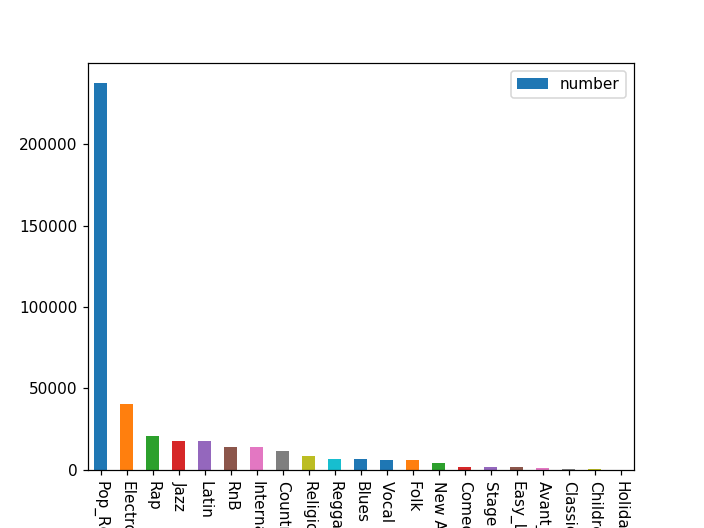

In [734]:
df.plot.bar(x='genre', y='number', rot=270)

In [814]:
# Q2b
# generate binary column
songs = songs_matched.withColumn("Class",
                        F.when((songs_matched.genre == "Electronic"), F.lit(1))
                        .otherwise(F.lit(0)))  
songs = songs.drop('genre')
songs.show(5)

+------------------+------+------+-------+-------+-------+-------+--------+-------+--------+--------+-----+-------+-------+--------+--------+--------+--------+-------+--------+--------+-----+
|                ID|  F001|  F002|   F003|   F004|   F005|   F006|    F007|   F008|    F009|    F010| F011|   F012|   F013|    F014|    F015|    F016|    F017|   F018|    F019|    F020|Class|
+------------------+------+------+-------+-------+-------+-------+--------+-------+--------+--------+-----+-------+-------+--------+--------+--------+--------+-------+--------+--------+-----+
|TRAAABD128F429CF47| 1.087|3359.0|20300.0|4.005E7|2.396E8|1.433E9|8.817E11|2.141E9|1.281E10|1.869E14|2.482| 5768.0|33690.0|-4.452E7|-2.623E8|-1.545E9|7.736E11|2.335E9|1.377E10|1.603E14|    0|
|TRAAGTO128F1497E3C|0.9806|3378.0|16290.0|4.036E7|1.975E8| 9.65E8|8.913E11|1.766E9| 8.639E9|1.049E14|1.011| 5776.0|29560.0|-4.474E7|-2.256E8|-1.137E9|7.802E11|2.005E9|1.012E10|9.757E13|    0|
|TRAAHAU128F9313A3D|0.6652|3354.0|26910.

In [815]:
# Compute class frequency

#show_as_html(songs.groupby('Class').count())
songs.groupby('Class').count().show()

+-----+------+
|Class| count|
+-----+------+
|    1| 40662|
|    0|379942|
+-----+------+



In [798]:
# Assemble numerical features into vector to compute correlations
inputCols = songs.columns[1:-1]

assembler = VectorAssembler(inputCols=inputCols, outputCol="features").setHandleInvalid("skip")

features = assembler.transform(songs).select(["features"])

show_as_html(features)

,features
0,"[1.2, 3355.0, 26270.0, 39850000.0, 309600000.0..."
1,"[1.883, 6712.0, 49060.0, 160600000.0, 11760000..."
2,"[1.363, 6710.0, 28750.0, 160500000.0, 69000000..."
3,"[0.8262, 3355.0, 17310.0, 39930000.0, 20800000..."
4,"[0.7786, 6717.0, 35320.0, 160900000.0, 8322000..."
5,"[2.191, 6742.0, 54680.0, 162100000.0, 13070000..."
6,"[1.702, 3354.0, 21520.0, 39960000.0, 262200000..."
7,"[0.4827, 6723.0, 60320.0, 161300000.0, 1449000..."
8,"[1.395, 3357.0, 14420.0, 39980000.0, 171000000..."
9,"[0.6198, 6712.0, 29890.0, 160700000.0, 7079000..."


In [780]:
features.printSchema()

root
 |-- features: vector (nullable = true)



In [767]:
#Normalize 
# Normalize each Vector using $L^1$ norm.
#normalizer = Normalizer(inputCol="features", outputCol="normFeatures", p=1.0)
#l1NormData = normalizer.transform(features)
#show_as_html(l1NormData)

,features,normFeatures
0,"[1.2, 3355.0, 26270.0, 39850000.0, 309600000.0...","[1.5913062265609778e-15, 4.449026991760067e-12..."
1,"[1.883, 6712.0, 49060.0, 160600000.0, 11760000...","[3.581533993595722e-16, 1.2766466364851028e-12..."
2,"[1.363, 6710.0, 28750.0, 160500000.0, 69000000...","[1.2708865710227874e-15, 6.256528900633091e-12..."
3,"[0.8262, 3355.0, 17310.0, 39930000.0, 20800000...","[3.4893914577228262e-15, 1.41695816275237e-11,..."
4,"[0.7786, 6717.0, 35320.0, 160900000.0, 8322000...","[4.157019047291521e-16, 3.5862698356867645e-12..."
5,"[2.191, 6742.0, 54680.0, 162100000.0, 13070000...","[3.105699672808615e-16, 9.556653215004876e-13,..."
6,"[1.702, 3354.0, 21520.0, 39960000.0, 262200000...","[3.643037048857144e-15, 7.179051857736111e-12,..."
7,"[0.4827, 6723.0, 60320.0, 161300000.0, 1449000...","[4.9196304567958295e-17, 6.852014825158144e-13..."
8,"[1.395, 3357.0, 14420.0, 39980000.0, 171000000...","[1.0531476831484699e-14, 2.5343489407379305e-1..."
9,"[0.6198, 6712.0, 29890.0, 160700000.0, 7079000...","[5.335201852437248e-16, 5.7776500215486945e-12..."


In [790]:
#features_norm = l1NormData.select(F.col("normFeatures"))
#features_norm.show(5)

+--------------------+
|        normFeatures|
+--------------------+
|[1.59130622656097...|
|[3.58153399359572...|
|[1.27088657102278...|
|[3.48939145772282...|
|[4.15701904729152...|
+--------------------+
only showing top 5 rows



In [799]:
# Calculate correlations and collect as array

correlations = Correlation.corr(features, 'features', 'pearson').collect()[0][0].toArray()

In [800]:
# Choose a threshold and visualize which correlations are above the threshold 

threshold = 0.95

display(pd.DataFrame(correlations.round(2)))
display(pd.DataFrame(correlations > threshold).astype(int))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.00,-0.03,0.19,0.01,0.06,0.09,0.02,0.06,0.09,0.04,0.71,-0.04,0.19,-0.01,-0.06,-0.09,0.02,0.06,0.09,0.04
1,-0.03,1.00,0.80,0.85,0.80,0.70,0.69,0.80,0.70,0.48,0.03,1.00,0.79,-0.85,-0.80,-0.70,0.69,0.80,0.70,0.48
2,0.19,0.80,1.00,0.69,0.79,0.80,0.56,0.79,0.80,0.54,0.32,0.80,0.99,-0.69,-0.79,-0.80,0.56,0.79,0.80,0.54
3,0.01,0.85,0.69,1.00,0.94,0.83,0.96,0.94,0.83,0.67,0.01,0.85,0.68,-1.00,-0.94,-0.82,0.96,0.94,0.82,0.67
4,0.06,0.80,0.79,0.94,1.00,0.96,0.91,1.00,0.96,0.82,0.09,0.80,0.79,-0.94,-1.00,-0.96,0.91,1.00,0.96,0.82
5,0.09,0.70,0.80,0.83,0.96,1.00,0.80,0.96,1.00,0.91,0.12,0.70,0.79,-0.83,-0.96,-1.00,0.80,0.96,1.00,0.91
6,0.02,0.69,0.56,0.96,0.91,0.80,1.00,0.91,0.80,0.70,-0.00,0.69,0.56,-0.96,-0.91,-0.79,1.00,0.91,0.79,0.70
7,0.06,0.80,0.79,0.94,1.00,0.96,0.91,1.00,0.96,0.82,0.09,0.80,0.79,-0.94,-1.00,-0.96,0.91,1.00,0.96,0.82
8,0.09,0.70,0.80,0.83,0.96,1.00,0.80,0.96,1.00,0.91,0.12,0.70,0.79,-0.83,-0.96,-1.00,0.79,0.96,1.00,0.91
9,0.04,0.48,0.54,0.67,0.82,0.91,0.70,0.82,0.91,1.00,0.03,0.48,0.54,-0.67,-0.82,-0.91,0.70,0.82,0.91,1.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,1,1,0
5,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,1,1,0
6,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
7,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,1,1,0
8,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,1,1,0
9,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [801]:
# Remove variable with the most correlations above the threshold iteratively until there are no correlations above the threshold

indexes = np.array(list(range(0, n)))  # we need to keep track of which features to keep based on their index from 0 to n - 1

matrix = correlations.copy()
for j in range(0, correlations.shape[0]):
    
    # determine the index of the feature with the most correlations above the threshold

    mask = matrix > threshold

    sums = mask.sum(axis=0)
    index = np.argmax(sums)  

    if sums[index] - 1 > 0:
        
        # remove the feature if there are any correlations above the threshold (other than the correlation with itself)
        
        k = matrix.shape[0]
        keep = [i for i in range(0, k) if i != index]
        matrix = matrix[keep, :][:, keep]
        indexes = indexes[keep]
        
    else:

        # otherwise stop iterating
        
        break

In [802]:
# Check the correlations of the remaining features to ensure they are all below the threshold 

correlations_remaining = correlations[indexes, :][:, indexes]  # index the submatrix of correlations of the remaining features

display(pd.DataFrame(correlations_remaining.round(2)))
display(pd.DataFrame(correlations_remaining > threshold).astype(int))

,0,1,2,3,4,5,6,7,8
0,1.00,0.71,-0.04,0.19,-0.01,-0.09,0.02,0.09,0.04
1,0.71,1.00,0.03,0.32,-0.01,-0.13,-0.00,0.12,0.03
2,-0.04,0.03,1.00,0.79,-0.85,-0.70,0.69,0.69,0.48
3,0.19,0.32,0.79,1.00,-0.68,-0.80,0.56,0.79,0.54
4,-0.01,-0.01,-0.85,-0.68,1.00,0.82,-0.96,-0.82,-0.67
5,-0.09,-0.13,-0.70,-0.80,0.82,1.00,-0.79,-1.00,-0.91
6,0.02,-0.00,0.69,0.56,-0.96,-0.79,1.00,0.79,0.69
7,0.09,0.12,0.69,0.79,-0.82,-1.00,0.79,1.00,0.91
8,0.04,0.03,0.48,0.54,-0.67,-0.91,0.69,0.91,1.00


,0,1,2,3,4,5,6,7,8
0,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,1,0,0,0
6,0,0,0,0,0,0,1,0,0
7,0,0,0,0,0,0,0,1,0
8,0,0,0,0,0,0,0,0,1


In [803]:
# Assemble reamining features into vector for modeling

inputCols = np.array(songs.columns[1:-1])[indexes]

assembler = VectorAssembler(inputCols=inputCols, outputCol="features").setHandleInvalid("skip")

features = assembler.transform(songs).select(["features"])

show_as_html(features)


,features
0,"[1.2, 3.201, 5746.0, 43470.0, -44220000.0, -25..."
1,"[1.883, 8.87, 11580.0, 85200.0, -179100000.0, ..."
2,"[1.363, 2.787, 11580.0, 49990.0, -179000000.0,..."
3,"[0.8262, 2.137, 5759.0, 30380.0, -44380000.0, ..."
4,"[0.7786, 1.112, 11600.0, 60300.0, -179600000.0..."
5,"[2.191, 5.563, 11650.0, 93180.0, -181100000.0,..."
6,"[1.702, 5.053, 5769.0, 37770.0, -44490000.0, -..."
7,"[0.4827, 6.758, 11610.0, 105500.0, -180000000...."
8,"[1.395, 3.519, 5763.0, 25150.0, -44440000.0, -..."
9,"[0.6198, 1.494, 11590.0, 51670.0, -179300000.0..."


In [804]:
# Select what we need

songs_updated = assembler.transform(songs)
songs_updated = songs_updated.select(
    F.col('Class').alias('label'),
    F.col('features'),
)

show_as_html(songs_updated)

,label,features
0,0,"[1.087, 2.482, 5768.0, 33690.0, -44520000.0, -..."
1,0,"[0.9806, 1.011, 5776.0, 29560.0, -44740000.0, ..."
2,0,"[0.6652, 2.592, 5768.0, 43290.0, -44470000.0, ..."
3,0,"[1.372, 1.868, 5788.0, 49760.0, -44770000.0, -..."
4,0,"[0.9336, 2.876, 11580.0, 73720.0, -179000000.0..."
5,0,"[1.145, 3.713, 11590.0, 60770.0, -179400000.0,..."
6,0,"[1.21, 4.053, 11590.0, 83700.0, -179200000.0, ..."
7,1,"[0.8185, 2.288, 11610.0, 78940.0, -180000000.0..."
8,0,"[1.833, 4.755, 5705.0, 44840.0, -43680000.0, -..."
9,0,"[0.8412, 1.525, 5951.0, 42460.0, -47360000.0, ..."


In [805]:
from pretty import SparkPretty  # download pretty.py from LEARN and put it in your M:\ or home directory
pretty = SparkPretty(limit=5)
print(pretty(songs_updated.head()))

Row(
  'features': DenseVector([1.087, 2.482, 5768.0, 33690.0, -44520000.0, -1545000000.0, 773600000000.0, 13770000000.0, 160300000000000.0]),
  'label': 0
)


In [816]:
#Q2c
# Exact stratification using Window (multi-class, counts computed on the fly)

temp = (
    songs_updated
    .withColumn("id", F.monotonically_increasing_id())
    .withColumn("random", F.rand())  # random number between 0 and 1
    .withColumn(
        "row",
        F.row_number()  # row number in each class partition (start at 0, 1, ... for positive and separately for negative)
        .over(
            Window
            .partitionBy("label")
            .orderBy("random")
        )
    )
)

counts = (
    songs_updated
    .groupBy("label")
    .count()
    .toPandas()
    .set_index("label")["count"]
    .to_dict()
)
labels = sorted(counts.keys())

# print(labels)
# print(counts)

training = temp
for label in labels:
    training = training.where((F.col("label") != label) | (F.col("row") < counts[label] * 0.8))

training.cache()

test = temp.join(training, on="id", how="left_anti")
test.cache()

training = training.drop("id", "random", "row")
test = test.drop("id", "random", "row")

print_class_balance(songs_updated, "songs_updated")
print_class_balance(training, "training")
print_class_balance(test, "test")

dataset: songs_updated
total:   420604
counts:
   label   count     ratio
0      1   40662  0.096675
1      0  379942  0.903325

dataset: training
total:   336482
counts:
   label   count     ratio
0      1   32529  0.096674
1      0  303953  0.903326

dataset: test
total:   84122
counts:
   label  count     ratio
0      1   8133  0.096681
1      0  75989  0.903319



In [810]:
# No sampling

lr = LogisticRegression(featuresCol='features', labelCol='label')
lr_model = lr.fit(training)
pred = lr_model.transform(test)
pred.cache()

print_metrics(pred, threshold=0.15)

metrics for custom threshold

threshold: 0.15

total:     84122

nP actual: 8133
nN actual: 75989

nP:        5300
nN:        78822

TP         1088
FP         4212
FN         7045
TN         71777

precision: 0.20528302
recall:    0.13377597
accuracy:  0.86618245

auroc:     0.62421291



In [817]:
# Observation reweighting

training_weighted = training.withColumn("weight", F.when(F.col("label") == 0, 1.0).when(F.col("label") == 1, 9.0).otherwise(1.0))

weights = (
    training_weighted
    .groupBy("label")
    .agg(
        F.collect_set(F.col("weight")).alias("weights")
    )
    .toPandas()
)
print(weights)



   label weights
0      1   [9.0]
1      0   [1.0]


In [839]:
#Q2d-e
# logistic regression
lr = LogisticRegression(featuresCol='features', labelCol='label', weightCol="weight")
lr_model = lr.fit(training_weighted)
pred = lr_model.transform(test)
pred.cache()

print_metrics(pred, threshold=0.6)

metrics for custom threshold

threshold: 0.6

total:     84122

nP actual: 8133
nN actual: 75989

nP:        8633
nN:        75489

TP         1680
FP         6953
FN         6453
TN         69036

precision: 0.19460211
recall:    0.20656584
accuracy:  0.84063622

auroc:     0.63777103



In [846]:
#Naive bayes

from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(smoothing=1.0, \
               modelType="gaussian", \
               featuresCol="features", \
               labelCol='label', weightCol="weight")
nb_model = nb.fit(training_weighted)
pred = nb_model.transform(test)
#pred.cache()

print_metrics(pred, threshold=0.5)

metrics for custom threshold

threshold: 0.5

total:     84122

nP actual: 8133
nN actual: 75989

nP:        419
nN:        83703

TP         111
FP         308
FN         8022
TN         75681

precision: 0.26491647
recall:    0.01364810
accuracy:  0.90097715

auroc:     0.58105136



In [844]:
# Gradient boosted tree

from pyspark.ml.classification import GBTClassifier
# Train a GBT model.
gbt = GBTClassifier(labelCol='label', \
                   featuresCol="features", weightCol="weight")
gbt_model = gbt.fit(training_weighted)
pred = gbt_model.transform(test)
#pred.cache()

print_metrics(pred, threshold=0.6)

metrics for custom threshold

threshold: 0.6

total:     84122

nP actual: 8133
nN actual: 75989

nP:        13476
nN:        70646

TP         3096
FP         10380
FN         5037
TN         65609

precision: 0.22974176
recall:    0.38067134
accuracy:  0.81673046

auroc:     0.71285936



In [828]:
# Without removing correlations
# Select what we need

assembler = VectorAssembler(
    inputCols=[col for col in songs.columns if col.startswith("F")],
    outputCol="features"
)

dat = assembler.transform(songs)
dat = dat.select(
    F.col('Class').alias('label'),
    F.col('features'),
)

show_as_html(dat)

,label,features
0,0,"[1.087, 3359.0, 20300.0, 40050000.0, 239600000..."
1,0,"[0.9806, 3378.0, 16290.0, 40360000.0, 19750000..."
2,0,"[0.6652, 3354.0, 26910.0, 39960000.0, 31470000..."
3,0,"[1.372, 3362.0, 29130.0, 40170000.0, 346700000..."
4,0,"[0.9336, 6711.0, 42110.0, 160500000.0, 1014000..."
5,0,"[1.145, 6717.0, 36280.0, 160800000.0, 85820000..."
6,0,"[1.21, 6713.0, 46410.0, 160700000.0, 112300000..."
7,1,"[0.8185, 6729.0, 46970.0, 161300000.0, 1111000..."
8,0,"[1.833, 3343.0, 25620.0, 39430000.0, 306500000..."
9,0,"[0.8412, 3461.0, 22670.0, 42560000.0, 29220000..."


In [829]:
from pretty import SparkPretty  # download pretty.py from LEARN and put it in your M:\ or home directory
pretty = SparkPretty(limit=5)
print(pretty(dat.head()))

Row(
  'features': DenseVector([1.087, 3359.0, 20300.0, 40050000.0, 239600000.0, 1433000000.0, 881700000000.0, 2141000000.0, 12810000000.0, 186900000000000.0, 2.482, 5768.0, 33690.0, -44520000.0, -262300000.0, -1545000000.0, 773600000000.0, 2335000000.0, 13770000000.0, 160300000000000.0]),
  'label': 0
)


In [830]:
# Exact stratification using Window (multi-class, counts computed on the fly)

temp = (
    dat
    .withColumn("id", F.monotonically_increasing_id())
    .withColumn("random", F.rand())  # random number between 0 and 1
    .withColumn(
        "row",
        F.row_number()  # row number in each class partition (start at 0, 1, ... for positive and separately for negative)
        .over(
            Window
            .partitionBy("label")
            .orderBy("random")
        )
    )
)

counts = (
    dat
    .groupBy("label")
    .count()
    .toPandas()
    .set_index("label")["count"]
    .to_dict()
)
labels = sorted(counts.keys())

# print(labels)
# print(counts)

training = temp
for label in labels:
    training = training.where((F.col("label") != label) | (F.col("row") < counts[label] * 0.8))

training.cache()

test = temp.join(training, on="id", how="left_anti")
test.cache()

training = training.drop("id", "random", "row")
test = test.drop("id", "random", "row")

print_class_balance(dat, "dat")
print_class_balance(training, "training")
print_class_balance(test, "test")

dataset: dat
total:   420604
counts:
   label   count     ratio
0      1   40662  0.096675
1      0  379942  0.903325

dataset: training
total:   336482
counts:
   label   count     ratio
0      1   32529  0.096674
1      0  303953  0.903326

dataset: test
total:   84122
counts:
   label  count     ratio
0      1   8133  0.096681
1      0  75989  0.903319



In [831]:
# Observation reweighting

training_weighted = training.withColumn("weight", F.when(F.col("label") == 0, 1.0).when(F.col("label") == 1, 9.0).otherwise(1.0))

weights = (
    training_weighted
    .groupBy("label")
    .agg(
        F.collect_set(F.col("weight")).alias("weights")
    )
    .toPandas()
)
print(weights)



   label weights
0      1   [9.0]
1      0   [1.0]


In [832]:
# Gradient boosted tree 

from pyspark.ml.classification import GBTClassifier
# Train a GBT model.
gbt = GBTClassifier(labelCol='label', \
                   featuresCol="features", weightCol="weight")
gbt_model = gbt.fit(training_weighted)
pred = gbt_model.transform(test)
#pred.cache()

print_metrics(pred)

metrics for custom threshold

threshold: 0.5

total:     84122

nP actual: 8133
nN actual: 75989

nP:        30515
nN:        53607

TP         5186
FP         25329
FN         2947
TN         50660

precision: 0.16994921
recall:    0.63764908
accuracy:  0.66386914

auroc:     0.71286021



In [852]:
#Q3b
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

gbparamGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [5, 10])
             .addGrid(gbt.maxBins, [20, 40])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

gbevaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

In [853]:
# Create 5-fold CrossValidator
gbcv = CrossValidator(estimator = gbt,
                      estimatorParamMaps = gbparamGrid,
                      evaluator = gbevaluator,
                      numFolds = 5)

In [854]:
gbcvModel = gbcv.fit(training_weighted)

In [855]:
pred = gbcvModel.transform(test)
print_metrics(pred)

metrics for custom threshold

threshold: 0.5

total:     84122

nP actual: 8133
nN actual: 75989

nP:        27277
nN:        56845

TP         4977
FP         22300
FN         3156
TN         53689

precision: 0.18246141
recall:    0.61195131
accuracy:  0.69739188

auroc:     0.72100027



In [488]:
#Multiclass Classification

In [856]:
# convert genre column to an integer index
songs_matched.show(10)

+------------------+------+------+-------+-------+-------+-------+--------+--------+--------+--------+-----+-------+-------+--------+--------+--------+--------+--------+--------+--------+-------------+
|                ID|  F001|  F002|   F003|   F004|   F005|   F006|    F007|    F008|    F009|    F010| F011|   F012|   F013|    F014|    F015|    F016|    F017|    F018|    F019|    F020|        genre|
+------------------+------+------+-------+-------+-------+-------+--------+--------+--------+--------+-----+-------+-------+--------+--------+--------+--------+--------+--------+--------+-------------+
|TRAAABD128F429CF47| 1.087|3359.0|20300.0|4.005E7|2.396E8|1.433E9|8.817E11| 2.141E9|1.281E10|1.869E14|2.482| 5768.0|33690.0|-4.452E7|-2.623E8|-1.545E9|7.736E11| 2.335E9|1.377E10|1.603E14|     Pop_Rock|
|TRAAGTO128F1497E3C|0.9806|3378.0|16290.0|4.036E7|1.975E8| 9.65E8|8.913E11| 1.766E9| 8.639E9|1.049E14|1.011| 5776.0|29560.0|-4.474E7|-2.256E8|-1.137E9|7.802E11| 2.005E9|1.012E10|9.757E13|     

In [857]:
# Q4b
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="genre", outputCol="class").fit(songs_matched)
indexed_songs = indexer.transform(songs_matched)
indexed_songs.show(10)

+------------------+------+------+-------+-------+-------+-------+--------+--------+--------+--------+-----+-------+-------+--------+--------+--------+--------+--------+--------+--------+-------------+-----+
|                ID|  F001|  F002|   F003|   F004|   F005|   F006|    F007|    F008|    F009|    F010| F011|   F012|   F013|    F014|    F015|    F016|    F017|    F018|    F019|    F020|        genre|class|
+------------------+------+------+-------+-------+-------+-------+--------+--------+--------+--------+-----+-------+-------+--------+--------+--------+--------+--------+--------+--------+-------------+-----+
|TRAAABD128F429CF47| 1.087|3359.0|20300.0|4.005E7|2.396E8|1.433E9|8.817E11| 2.141E9|1.281E10|1.869E14|2.482| 5768.0|33690.0|-4.452E7|-2.623E8|-1.545E9|7.736E11| 2.335E9|1.377E10|1.603E14|     Pop_Rock|  0.0|
|TRAAGTO128F1497E3C|0.9806|3378.0|16290.0|4.036E7|1.975E8| 9.65E8|8.913E11| 1.766E9| 8.639E9|1.049E14|1.011| 5776.0|29560.0|-4.474E7|-2.256E8|-1.137E9|7.802E11| 2.005E9

In [858]:
# Q4c
# Assemble numerical features into vector to compute correlations

assembler = VectorAssembler(
    inputCols=[col for col in indexed_songs.columns if col.startswith("F")],
    outputCol="features"
).setHandleInvalid("skip")

features = assembler.transform(indexed_songs).select(["features"])

show_as_html(features)

,features
0,"[1.2, 3355.0, 26270.0, 39850000.0, 309600000.0..."
1,"[1.883, 6712.0, 49060.0, 160600000.0, 11760000..."
2,"[1.363, 6710.0, 28750.0, 160500000.0, 69000000..."
3,"[0.8262, 3355.0, 17310.0, 39930000.0, 20800000..."
4,"[0.7786, 6717.0, 35320.0, 160900000.0, 8322000..."
5,"[2.191, 6742.0, 54680.0, 162100000.0, 13070000..."
6,"[1.702, 3354.0, 21520.0, 39960000.0, 262200000..."
7,"[0.4827, 6723.0, 60320.0, 161300000.0, 1449000..."
8,"[1.395, 3357.0, 14420.0, 39980000.0, 171000000..."
9,"[0.6198, 6712.0, 29890.0, 160700000.0, 7079000..."


In [859]:
# Calculate correlations and collect as array

correlations = Correlation.corr(features, 'features', 'pearson').collect()[0][0].toArray()

In [860]:
threshold = 0.95
# Remove variable with the most correlations above the threshold iteratively until there are no correlations above the threshold

indexes = np.array(list(range(0, n)))  # we need to keep track of which features to keep based on their index from 0 to n - 1

matrix = correlations.copy()
for j in range(0, correlations.shape[0]):
    
    # determine the index of the feature with the most correlations above the threshold

    mask = matrix > threshold

    sums = mask.sum(axis=0)
    index = np.argmax(sums)  

    if sums[index] - 1 > 0:
        
        # remove the feature if there are any correlations above the threshold (other than the correlation with itself)
        
        k = matrix.shape[0]
        keep = [i for i in range(0, k) if i != index]
        matrix = matrix[keep, :][:, keep]
        indexes = indexes[keep]
        
    else:

        # otherwise stop iterating
        
        break

In [304]:
indexed_songs.show(5)

+------------------+------+------+-------+-------+-------+-------+--------+-------+--------+--------+-----+-------+-------+--------+--------+--------+--------+-------+--------+--------+-------------+-----+
|                ID|  F001|  F002|   F003|   F004|   F005|   F006|    F007|   F008|    F009|    F010| F011|   F012|   F013|    F014|    F015|    F016|    F017|   F018|    F019|    F020|        genre|class|
+------------------+------+------+-------+-------+-------+-------+--------+-------+--------+--------+-----+-------+-------+--------+--------+--------+--------+-------+--------+--------+-------------+-----+
|TRAAABD128F429CF47| 1.087|3359.0|20300.0|4.005E7|2.396E8|1.433E9|8.817E11|2.141E9|1.281E10|1.869E14|2.482| 5768.0|33690.0|-4.452E7|-2.623E8|-1.545E9|7.736E11|2.335E9|1.377E10|1.603E14|     Pop_Rock|  0.0|
|TRAAGTO128F1497E3C|0.9806|3378.0|16290.0|4.036E7|1.975E8| 9.65E8|8.913E11|1.766E9| 8.639E9|1.049E14|1.011| 5776.0|29560.0|-4.474E7|-2.256E8|-1.137E9|7.802E11|2.005E9|1.012E10|

In [861]:
# Check the correlations of the remaining features to ensure they are all below the threshold 

correlations_left = correlations[indexes, :][:, indexes]  # index the submatrix of correlations of the remaining features

display(pd.DataFrame(correlations_left.round(2)))
display(pd.DataFrame(correlations_left > threshold).astype(int))

,0,1,2,3,4,5,6,7,8
0,1.00,0.71,-0.04,0.19,-0.01,-0.09,0.02,0.09,0.04
1,0.71,1.00,0.03,0.32,-0.01,-0.13,-0.00,0.12,0.03
2,-0.04,0.03,1.00,0.79,-0.85,-0.70,0.69,0.69,0.48
3,0.19,0.32,0.79,1.00,-0.68,-0.80,0.56,0.79,0.54
4,-0.01,-0.01,-0.85,-0.68,1.00,0.82,-0.96,-0.82,-0.67
5,-0.09,-0.13,-0.70,-0.80,0.82,1.00,-0.79,-1.00,-0.91
6,0.02,-0.00,0.69,0.56,-0.96,-0.79,1.00,0.79,0.69
7,0.09,0.12,0.69,0.79,-0.82,-1.00,0.79,1.00,0.91
8,0.04,0.03,0.48,0.54,-0.67,-0.91,0.69,0.91,1.00


,0,1,2,3,4,5,6,7,8
0,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,1,0,0,0
6,0,0,0,0,0,0,1,0,0
7,0,0,0,0,0,0,0,1,0
8,0,0,0,0,0,0,0,0,1


In [862]:
# Assemble reamining features into vector for modeling

inputCols = np.array(indexed_songs.columns[1:-1])[indexes]

assembler = VectorAssembler(inputCols=inputCols, outputCol="features").setHandleInvalid("skip")

features = assembler.transform(indexed_songs).select(["features"])

show_as_html(features)

,features
0,"[1.2, 3.201, 5746.0, 43470.0, -44220000.0, -25..."
1,"[1.883, 8.87, 11580.0, 85200.0, -179100000.0, ..."
2,"[1.363, 2.787, 11580.0, 49990.0, -179000000.0,..."
3,"[0.8262, 2.137, 5759.0, 30380.0, -44380000.0, ..."
4,"[0.7786, 1.112, 11600.0, 60300.0, -179600000.0..."
5,"[2.191, 5.563, 11650.0, 93180.0, -181100000.0,..."
6,"[1.702, 5.053, 5769.0, 37770.0, -44490000.0, -..."
7,"[0.4827, 6.758, 11610.0, 105500.0, -180000000...."
8,"[1.395, 3.519, 5763.0, 25150.0, -44440000.0, -..."
9,"[0.6198, 1.494, 11590.0, 51670.0, -179300000.0..."


In [863]:
# Calculate new correlations and collect as array

correlations_new = Correlation.corr(features, 'features', 'pearson').collect()[0][0].toArray()

In [864]:
# Choose a threshold and visualize which correlations are above the threshold 

threshold = 0.95

display(pd.DataFrame(correlations_new.round(2)))
display(pd.DataFrame(correlations_new > threshold).astype(int))



,0,1,2,3,4,5,6,7,8
0,1.00,0.71,-0.04,0.19,-0.01,-0.09,0.02,0.09,0.04
1,0.71,1.00,0.03,0.32,-0.01,-0.13,-0.00,0.12,0.03
2,-0.04,0.03,1.00,0.79,-0.85,-0.70,0.69,0.69,0.48
3,0.19,0.32,0.79,1.00,-0.68,-0.80,0.56,0.79,0.54
4,-0.01,-0.01,-0.85,-0.68,1.00,0.82,-0.96,-0.82,-0.67
5,-0.09,-0.13,-0.70,-0.80,0.82,1.00,-0.79,-1.00,-0.91
6,0.02,-0.00,0.69,0.56,-0.96,-0.79,1.00,0.79,0.69
7,0.09,0.12,0.69,0.79,-0.82,-1.00,0.79,1.00,0.91
8,0.04,0.03,0.48,0.54,-0.67,-0.91,0.69,0.91,1.00


,0,1,2,3,4,5,6,7,8
0,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,1,0,0,0
6,0,0,0,0,0,0,1,0,0
7,0,0,0,0,0,0,0,1,0
8,0,0,0,0,0,0,0,0,1


In [865]:
# Select what we need

indexed_songs_updated = assembler.transform(indexed_songs)
indexed_songs_updated = indexed_songs_updated.select(
    F.col('Class').alias('label'),
    F.col('features')
)

show_as_html(indexed_songs_updated)

,label,features
0,0.0,"[1.087, 2.482, 5768.0, 33690.0, -44520000.0, -..."
1,0.0,"[0.9806, 1.011, 5776.0, 29560.0, -44740000.0, ..."
2,0.0,"[0.6652, 2.592, 5768.0, 43290.0, -44470000.0, ..."
3,2.0,"[1.372, 1.868, 5788.0, 49760.0, -44770000.0, -..."
4,6.0,"[0.9336, 2.876, 11580.0, 73720.0, -179000000.0..."
5,0.0,"[1.145, 3.713, 11590.0, 60770.0, -179400000.0,..."
6,6.0,"[1.21, 4.053, 11590.0, 83700.0, -179200000.0, ..."
7,1.0,"[0.8185, 2.288, 11610.0, 78940.0, -180000000.0..."
8,9.0,"[1.833, 4.755, 5705.0, 44840.0, -43680000.0, -..."
9,0.0,"[0.8412, 1.525, 5951.0, 42460.0, -47360000.0, ..."


In [866]:
print(pretty(indexed_songs_updated.head()))

Row(
  'features': DenseVector([1.087, 2.482, 5768.0, 33690.0, -44520000.0, -1545000000.0, 773600000000.0, 13770000000.0, 160300000000000.0]),
  'label': 0.0
)


In [970]:
temp = (
  indexed_songs
  .groupBy(["genre","class"])
  .agg(
    F.countDistinct(F.col("ID")).cast(IntegerType()).alias("count"),
  )
    .sort(F.col("class"))
)    
    
temp.show(25)

+--------------+-----+------+
|         genre|class| count|
+--------------+-----+------+
|      Pop_Rock|  0.0|237641|
|    Electronic|  1.0| 40662|
|           Rap|  2.0| 20899|
|          Jazz|  3.0| 17775|
|         Latin|  4.0| 17504|
|           RnB|  5.0| 14314|
| International|  6.0| 14194|
|       Country|  7.0| 11691|
|     Religious|  8.0|  8779|
|        Reggae|  9.0|  6928|
|         Blues| 10.0|  6801|
|         Vocal| 11.0|  6182|
|          Folk| 12.0|  5789|
|       New Age| 13.0|  4000|
| Comedy_Spoken| 14.0|  2067|
|        Stage | 15.0|  1613|
|Easy_Listening| 16.0|  1535|
|   Avant_Garde| 17.0|  1012|
|     Classical| 18.0|   555|
|      Children| 19.0|   463|
|       Holiday| 20.0|   200|
+--------------+-----+------+



In [496]:
# Without removing correlations
# Select what we need

assembler = VectorAssembler(
    inputCols=[col for col in indexed_songs.columns if col.startswith("F")],
    outputCol="features"
)

dat = assembler.transform(indexed_songs)
dat = dat.select(
    F.col('genre'),
    F.col('Class').alias('label'),
    F.col('features'),
)

show_as_html(dat)


,genre,label,features
0,Pop_Rock,0.0,"[1.087, 3359.0, 20300.0, 40050000.0, 239600000..."
1,Pop_Rock,0.0,"[0.9806, 3378.0, 16290.0, 40360000.0, 19750000..."
2,Pop_Rock,0.0,"[0.6652, 3354.0, 26910.0, 39960000.0, 31470000..."
3,Rap,2.0,"[1.372, 3362.0, 29130.0, 40170000.0, 346700000..."
4,International,6.0,"[0.9336, 6711.0, 42110.0, 160500000.0, 1014000..."
5,Pop_Rock,0.0,"[1.145, 6717.0, 36280.0, 160800000.0, 85820000..."
6,International,6.0,"[1.21, 6713.0, 46410.0, 160700000.0, 112300000..."
7,Electronic,1.0,"[0.8185, 6729.0, 46970.0, 161300000.0, 1111000..."
8,Reggae,9.0,"[1.833, 3343.0, 25620.0, 39430000.0, 306500000..."
9,Pop_Rock,0.0,"[0.8412, 3461.0, 22670.0, 42560000.0, 29220000..."


In [333]:
print(pretty(dat.head()))

Row(
  'features': DenseVector([1.087, 3359.0, 20300.0, 40050000.0, 239600000.0, 1433000000.0, 881700000000.0, 2141000000.0, 12810000000.0, 186900000000000.0, 2.482, 5768.0, 33690.0, -44520000.0, -262300000.0, -1545000000.0, 773600000000.0, 2335000000.0, 13770000000.0, 160300000000000.0]),
  'genre': 'Pop_Rock',
  'label': 0.0
)


In [497]:
# Exact stratification using Window (multi-class, counts computed on the fly)

temp = (
    dat
    .withColumn("id", F.monotonically_increasing_id())
    .withColumn("random", F.rand())  # random number between 0 and 1
    .withColumn(
        "row",
        F.row_number()  # row number in each class partition (start at 0, 1, ... for positive and separately for negative)
        .over(
            Window
            .partitionBy("label")
            .orderBy("random")
        )
    )
)

counts = (
    dat
    .groupBy("label")
    .count()
    .toPandas()
    .set_index("label")["count"]
    .to_dict()
)
labels = sorted(counts.keys())

# print(labels)
# print(counts)

training = temp
for label in labels:
    training = training.where((F.col("label") != label) | (F.col("row") < counts[label] * 0.8))

training.cache()

test = temp.join(training, on="id", how="left_anti")
test.cache()

training = training.drop("id", "random", "row")
test = test.drop("id", "random", "row")

print_class_balance(dat, "dat")
print_class_balance(training, "training")
print_class_balance(test, "test")

dataset: dat
total:   420604
counts:
    label   count     ratio
0    13.0    4000  0.009510
1     6.0   14194  0.033747
2    16.0    1535  0.003650
3    19.0     463  0.001101
4     7.0   11691  0.027796
5     4.0   17504  0.041616
6    20.0     200  0.000476
7     9.0    6928  0.016472
8    18.0     555  0.001320
9     3.0   17775  0.042261
10   11.0    6182  0.014698
11   12.0    5789  0.013764
12    1.0   40662  0.096675
13   10.0    6801  0.016170
14    5.0   14314  0.034032
15   17.0    1012  0.002406
16    8.0    8779  0.020872
17   14.0    2067  0.004914
18    0.0  237641  0.564999
19    2.0   20899  0.049688
20   15.0    1613  0.003835

dataset: training
total:   336471
counts:
    label   count     ratio
0     6.0   11355  0.033747
1    13.0    3199  0.009508
2    16.0    1227  0.003647
3    19.0     370  0.001100
4     7.0    9352  0.027794
5     4.0   14003  0.041617
6    20.0     159  0.000473
7     9.0    5542  0.016471
8    18.0     443  0.001317
9     3.0   14219  0.042

In [498]:
training.show(5)

+-------------+-----+--------------------+
|        genre|label|            features|
+-------------+-----+--------------------+
|International|  6.0|[0.4912,6721.0,23...|
|International|  6.0|[1.061,6719.0,585...|
|International|  6.0|[1.337,6719.0,444...|
|International|  6.0|[1.041,6712.0,456...|
|International|  6.0|[0.447,3357.0,130...|
+-------------+-----+--------------------+
only showing top 5 rows



In [499]:
# Downsampling

training_downsampled = (
    training
    .withColumn("random", F.rand())
    .where((F.col("label") != 0) | ((F.col("label") == 0) & (F.col("random") < 2 * (20000 / 237641))))
)
training_downsampled.cache()

print_class_balance(training_downsampled, "training (downsampled)")

dataset: training (downsampled)
total:   178255
counts:
    label  count     ratio
0     6.0  11355  0.063701
1    13.0   3199  0.017946
2    16.0   1227  0.006883
3    19.0    370  0.002076
4     7.0   9352  0.052464
5     4.0  14003  0.078556
6    20.0    159  0.000892
7     9.0   5542  0.031090
8    18.0    443  0.002485
9     3.0  14219  0.079768
10   11.0   4945  0.027741
11   12.0   4631  0.025980
12    1.0  32529  0.182486
13   10.0   5440  0.030518
14    5.0  11451  0.064239
15   17.0    809  0.004538
16    8.0   7023  0.039399
17   14.0   1653  0.009273
18    0.0  31896  0.178935
19    2.0  16719  0.093793
20   15.0   1290  0.007237



In [868]:
#Removing correlations
# Exact stratification using Window (multi-class, counts computed on the fly)

temp = (
    indexed_songs_updated
    .withColumn("id", F.monotonically_increasing_id())
    .withColumn("random", F.rand())  # random number between 0 and 1
    .withColumn(
        "row",
        F.row_number()  # row number in each class partition (start at 0, 1, ... for positive and separately for negative)
        .over(
            Window
            .partitionBy("label")
            .orderBy("random")
        )
    )
)

counts = (
    indexed_songs_updated
    .groupBy("label")
    .count()
    .toPandas()
    .set_index("label")["count"]
    .to_dict()
)
labels = sorted(counts.keys())

# print(labels)
# print(counts)

training = temp
for label in labels:
    training = training.where((F.col("label") != label) | (F.col("row") < counts[label] * 0.8))

training.cache()

test = temp.join(training, on="id", how="left_anti")
test.cache()

training = training.drop("id", "random", "row")
test = test.drop("id", "random", "row")

print_class_balance(indexed_songs_updated, "indexed_songs_updated")
print_class_balance(training, "training")
print_class_balance(test, "test")

dataset: indexed_songs_updated
total:   420604
counts:
    label   count     ratio
0    13.0    4000  0.009510
1     6.0   14194  0.033747
2    16.0    1535  0.003650
3    19.0     463  0.001101
4     7.0   11691  0.027796
5     4.0   17504  0.041616
6    20.0     200  0.000476
7     9.0    6928  0.016472
8    18.0     555  0.001320
9     3.0   17775  0.042261
10   11.0    6182  0.014698
11   12.0    5789  0.013764
12    1.0   40662  0.096675
13   10.0    6801  0.016170
14    5.0   14314  0.034032
15   17.0    1012  0.002406
16    8.0    8779  0.020872
17   14.0    2067  0.004914
18    0.0  237641  0.564999
19    2.0   20899  0.049688
20   15.0    1613  0.003835

dataset: training
total:   336471
counts:
    label   count     ratio
0     6.0   11355  0.033747
1    13.0    3199  0.009508
2    16.0    1227  0.003647
3    19.0     370  0.001100
4     7.0    9352  0.027794
5     4.0   14003  0.041617
6    20.0     159  0.000473
7     9.0    5542  0.016471
8    18.0     443  0.001317
9     

In [932]:
# Downsampling

training_downsampled = (
    training
    .withColumn("random", F.rand())
    .where(((F.col("label") != 0) | ((F.col("label") == 0) & (F.col("random") < 2 * (10000 / 237641)))) & ((F.col("label") != 1) | ((F.col("label") == 1) & (F.col("random") < 2 * (10000 / 40662)))))
)
training_downsampled.cache()


print_class_balance(training_downsampled, "training (downsampled)")

dataset: training (downsampled)
total:   146105
counts:
    label  count     ratio
0     6.0  11355  0.077718
1    13.0   3199  0.021895
2    16.0   1227  0.008398
3    19.0    370  0.002532
4     7.0   9352  0.064009
5     4.0  14003  0.095842
6    20.0    159  0.001088
7     9.0   5542  0.037932
8    18.0    443  0.003032
9     3.0  14219  0.097320
10   11.0   4945  0.033846
11   12.0   4631  0.031696
12    1.0  15929  0.109024
13   10.0   5440  0.037233
14    5.0  11451  0.078375
15   17.0    809  0.005537
16    8.0   7023  0.048068
17   14.0   1653  0.011314
18    0.0  16346  0.111878
19    2.0  16719  0.114431
20   15.0   1290  0.008829



In [888]:
# Training without downsampling
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(training)
predictions = lrModel.transform(test)

In [953]:
#Training downsampled
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(training_downsampled)
predictions = lrModel.transform(test)

In [954]:
predictions.filter(predictions['prediction'] == 0).count()

25863

In [955]:
trainingSummary = lrModel.summary

In [956]:
# for multiclass, we can inspect metrics on a per-label basis
print("False positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

False positive rate by label:
label 0: 0.1791860294854307
label 1: 0.09457964601769911
label 2: 0.31055137340979705
label 3: 0.3228166750072032
label 4: 1.51398162026313e-05
label 5: 0.0
label 6: 0.0
label 7: 0.0
label 8: 0.0
label 9: 0.0
label 10: 0.0
label 11: 0.0
label 12: 0.0
label 13: 0.0
label 14: 0.0
label 15: 0.0
label 16: 0.0
label 17: 0.0
label 18: 0.0
label 19: 0.0
label 20: 0.0


In [957]:
print("True positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

True positive rate by label:
label 0: 0.39758962437293527
label 1: 0.1234226881787934
label 2: 0.6212094024762247
label 3: 0.6281735705745833
label 4: 7.141326858530314e-05
label 5: 0.0
label 6: 0.0
label 7: 0.0
label 8: 0.0
label 9: 0.0
label 10: 0.0
label 11: 0.0
label 12: 0.0
label 13: 0.0
label 14: 0.0
label 15: 0.0
label 16: 0.0
label 17: 0.0
label 18: 0.0
label 19: 0.0
label 20: 0.0


In [959]:
print("Precision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

Precision by label:
label 0: 0.21845378151260506
label 1: 0.1376943549516739
label 2: 0.20539086756184863
label 3: 0.17341332246102473
label 4: 0.3333333333333333
label 5: 0.0
label 6: 0.0
label 7: 0.0
label 8: 0.0
label 9: 0.0
label 10: 0.0
label 11: 0.0
label 12: 0.0
label 13: 0.0
label 14: 0.0
label 15: 0.0
label 16: 0.0
label 17: 0.0
label 18: 0.0
label 19: 0.0
label 20: 0.0


In [960]:
print("Recall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

Recall by label:
label 0: 0.39758962437293527
label 1: 0.1234226881787934
label 2: 0.6212094024762247
label 3: 0.6281735705745833
label 4: 7.141326858530314e-05
label 5: 0.0
label 6: 0.0
label 7: 0.0
label 8: 0.0
label 9: 0.0
label 10: 0.0
label 11: 0.0
label 12: 0.0
label 13: 0.0
label 14: 0.0
label 15: 0.0
label 16: 0.0
label 17: 0.0
label 18: 0.0
label 19: 0.0
label 20: 0.0


In [961]:
accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nPrecision: %s\nRecall: %s"
        % (accuracy, falsePositiveRate, truePositiveRate, precision, recall))

Accuracy: 0.19016460764518667
FPR: 0.09731347138151933
TPR: 0.19016460764518667
Precision: 0.11177947028600513
Recall: 0.19016460764518667


In [454]:
#Song recommendations
triplets.show(10)

+--------------------+------------------+-----+
|             user_id|           song_id|plays|
+--------------------+------------------+-----+
|f1bfc2a4597a3642f...|SOQEFDN12AB017C52B|    1|
|f1bfc2a4597a3642f...|SOQOIUJ12A6701DAA7|    2|
|f1bfc2a4597a3642f...|SOQOKKD12A6701F92E|    4|
|f1bfc2a4597a3642f...|SOSDVHO12AB01882C7|    1|
|f1bfc2a4597a3642f...|SOSKICX12A6701F932|    1|
|f1bfc2a4597a3642f...|SOSNUPV12A8C13939B|    1|
|f1bfc2a4597a3642f...|SOSVMII12A6701F92D|    1|
|f1bfc2a4597a3642f...|SOTUNHI12B0B80AFE2|    1|
|f1bfc2a4597a3642f...|SOTXLTZ12AB017C535|    1|
|f1bfc2a4597a3642f...|SOTZDDX12A6701F935|    1|
+--------------------+------------------+-----+
only showing top 10 rows



In [971]:
triplets_not_mismatched.show(10)

+------------------+--------------------+-----+
|           song_id|             user_id|plays|
+------------------+--------------------+-----+
|SOAAADE12A6D4F80CC|21cd3a6311fc6820e...|    1|
|SOAAADE12A6D4F80CC|a9777925ab522473c...|    1|
|SOAAADE12A6D4F80CC|992fa95473cc053aa...|    1|
|SOAAADE12A6D4F80CC|736f40dcc9e45e2f0...|    2|
|SOAAADE12A6D4F80CC|f4058a3849ba9ef1a...|    3|
|SOAAADE12A6D4F80CC|1c21e65e0e67ecc08...|    1|
|SOAAADE12A6D4F80CC|edfc4dea143a03f06...|    1|
|SOAAADE12A6D4F80CC|ae6b5e9dbfdd799f2...|    1|
|SOAAADE12A6D4F80CC|335253b4d6f0baedd...|    1|
|SOAACBK12A67ADD198|65206d7a1a01543fe...|    8|
+------------------+--------------------+-----+
only showing top 10 rows



In [455]:
triplets.count()

48373586

In [972]:
# Q1a
triplets_not_mismatched.count()

45795111

In [973]:
triplets_not_mismatched.select('song_id').distinct().count()

378310

In [974]:
triplets_not_mismatched.select('user_id').distinct().count()

1019318

In [975]:
#Q1b
temp_user = (
  triplets_not_mismatched
  .groupBy(["user_id"])
  .agg(
    F.countDistinct(F.col("song_id")).cast(IntegerType()).alias("different song count"),
    F.sum(F.col("plays")).cast(IntegerType()).alias("total play count"),
  )
    .sort(F.col("total play count").desc())
)    
    
temp_user.show(10)

+--------------------+--------------------+----------------+
|             user_id|different song count|total play count|
+--------------------+--------------------+----------------+
|093cb74eb3c517c51...|                 195|           13074|
|119b7c88d58d0c6eb...|                1362|            9104|
|3fa44653315697f42...|                 146|            8025|
|a2679496cd0af9779...|                 518|            6506|
|d7d2d888ae04d16e9...|                1257|            6190|
|4ae01afa8f2430ea0...|                 453|            6153|
|b7c24f770be6b8028...|                1364|            5827|
|113255a012b2affea...|                1096|            5471|
|99ac3d883681e21ea...|                 939|            5385|
|6d625c6557df84b60...|                1307|            5362|
+--------------------+--------------------+----------------+
only showing top 10 rows



In [979]:
temp_user = (
  triplets_not_mismatched
  .groupBy(["user_id"])
  .agg(
    F.countDistinct(F.col("song_id")).cast(IntegerType()).alias("different song count")
  )
    .sort(F.col("different song count").desc())
)    
    
temp_user.show(10)

+--------------------+--------------------+
|             user_id|different song count|
+--------------------+--------------------+
|ec6dfcf19485cb011...|                4316|
|8cb51abc6bf8ea293...|                1562|
|5a3417a1955d91364...|                1557|
|fef771ab021c20018...|                1545|
|c1255748c06ee3f64...|                1498|
|4e73d9e058d2b1f2d...|                1470|
|cbc7bddbe3b2f59fd...|                1457|
|96f7b4f800cafef33...|                1407|
|b7c24f770be6b8028...|                1364|
|119b7c88d58d0c6eb...|                1362|
+--------------------+--------------------+
only showing top 10 rows



<IPython.core.display.Javascript object>


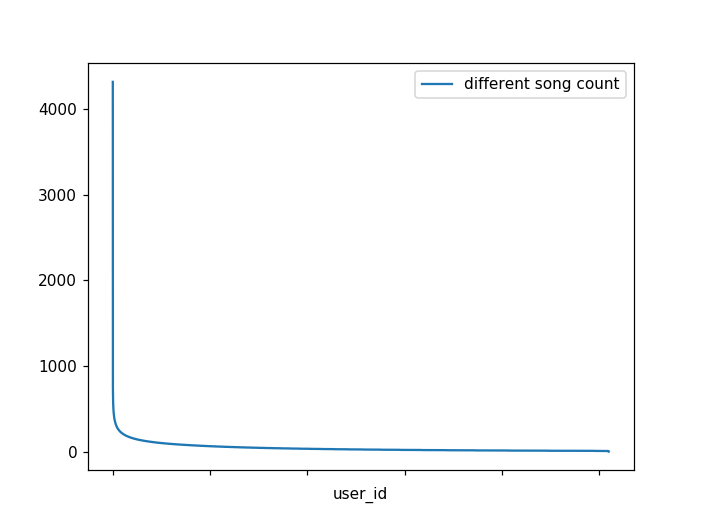

In [983]:
#Q1c
#user activity
df = temp_user.toPandas()
df
df.plot.line(x="user_id", y="different song count")

In [984]:
temp_song = (
  triplets_not_mismatched
  .groupBy(["song_id"])
  .agg(
    F.countDistinct(F.col("user_id")).cast(IntegerType()).alias("different user count"),
    F.sum(F.col("plays")).cast(IntegerType()).alias("total play count"),
  )
    .sort(F.col("total play count").desc())
)    
    
temp_song.show(10)

+------------------+--------------------+----------------+
|           song_id|different user count|total play count|
+------------------+--------------------+----------------+
|SOBONKR12A58A7A7E0|               84000|          726885|
|SOSXLTC12AF72A7F54|               80656|          527893|
|SOEGIYH12A6D4FC0E3|               69487|          389880|
|SOAXGDH12A8C13F8A1|               90444|          356533|
|SONYKOW12AB01849C9|               78353|          292642|
|SOPUCYA12A8C13A694|               46078|          274627|
|SOUFTBI12AB0183F65|               37642|          268353|
|SOVDSJC12A58A7A271|               36976|          244730|
|SOOFYTN12A6D4F9B35|               40403|          241669|
|SOHTKMO12AB01843B0|               46077|          236494|
+------------------+--------------------+----------------+
only showing top 10 rows



In [985]:
temp_song = (
  triplets_not_mismatched
  .groupBy(["song_id"])
  .agg(
    F.countDistinct(F.col("user_id")).cast(IntegerType()).alias("different user count")
  )
    .sort(F.col("different user count").desc())
)    
    
temp_song.show(10)

+------------------+--------------------+
|           song_id|different user count|
+------------------+--------------------+
|SOAXGDH12A8C13F8A1|               90444|
|SOBONKR12A58A7A7E0|               84000|
|SOSXLTC12AF72A7F54|               80656|
|SONYKOW12AB01849C9|               78353|
|SOEGIYH12A6D4FC0E3|               69487|
|SOLFXKT12AB017E3E0|               64229|
|SOFLJQZ12A6D4FADA6|               58610|
|SOUSMXX12AB0185C24|               53260|
|SOWCKVR12A8C142411|               52080|
|SOUVTSM12AC468F6A7|               51022|
+------------------+--------------------+
only showing top 10 rows



<IPython.core.display.Javascript object>


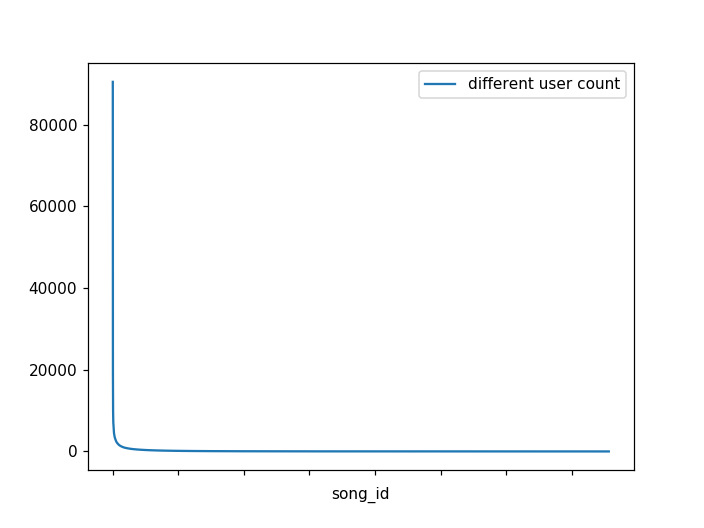

In [986]:
#song popularity
df = temp_song.toPandas()
df
df.plot.line(x="song_id", y="different user count")

In [991]:
temp_song.count()

378310

In [993]:
temp_user.count()

1019318

In [992]:
#Q1d
songs_retained = temp_song.select('song_id').where(F.col('different user count')>50)
songs_retained.count()

94317

In [995]:
users_retained = temp_user.select('user_id').where(F.col('different song count')>50)
users_retained.count()

266306

In [996]:
#Merge songs_retained and triplet not mismatched
songs_high = triplets_not_mismatched.join(songs_retained, on="song_id", how="inner")
songs_high.show(5)


+------------------+--------------------+-----+
|           song_id|             user_id|plays|
+------------------+--------------------+-----+
|SOAAISU12AF72A44D3|458f04bec925f8bce...|    1|
|SOAAISU12AF72A44D3|faaf58b26829fd002...|    1|
|SOAAISU12AF72A44D3|e0e0ac904248e692e...|    2|
|SOAAISU12AF72A44D3|9a5802ab85a088cd8...|    1|
|SOAAISU12AF72A44D3|0f6c6722129de8499...|    1|
+------------------+--------------------+-----+
only showing top 5 rows



In [997]:
#Merge users_retained and songs_high
songs_users_high = songs_high.join(users_retained, on="user_id", how="inner")
songs_users_high.show(5)

+--------------------+------------------+-----+
|             user_id|           song_id|plays|
+--------------------+------------------+-----+
|0030bfca05740e85c...|SOBXHDL12A81C204C0|    5|
|0030bfca05740e85c...|SOIZFTE12AB0186842|    3|
|0030bfca05740e85c...|SOPJHQC12A6701F6CB|    5|
|0030bfca05740e85c...|SOKQOJY12AAF3B531C|    2|
|0030bfca05740e85c...|SOELLWI12A58A77EDC|    4|
+--------------------+------------------+-----+
only showing top 5 rows



In [383]:
temp = (
  songs_users_high
  .groupBy(["user_id"])
  .agg(
    F.countDistinct(F.col("song_id")).cast(IntegerType()).alias("different count"),
    F.sum(F.col("plays")).cast(IntegerType()).alias("total count"),
  )
    .sort(F.col("total count"))
)    
    
temp.show(10)

+--------------------+---------------+-----------+
|             user_id|different count|total count|
+--------------------+---------------+-----------+
|3c67b4c22ac0d7d41...|              2|          3|
|54d9527096f986d16...|              1|          5|
|9a670a256be29d16c...|              9|         10|
|d6f9434b074024868...|              5|         10|
|e0e4fc00ce8e3d176...|              4|         10|
|6ec351fd287af6bad...|              8|         11|
|1ce9526fbe1db0101...|              6|         11|
|0ee2aa64a8d968e13...|              5|         11|
|dc27503988230f466...|             10|         12|
|e2f1c909bd152c3a5...|              6|         15|
+--------------------+---------------+-----------+
only showing top 10 rows



In [998]:
songs_users_high.count()

26717500

In [999]:
songs_users_high.select('song_id').distinct().count()

94317

In [1000]:
songs_users_high.select('user_id').distinct().count()

266306

In [1001]:
# Convert user_id and song_id to numerical values
indexer = StringIndexer(inputCol="user_id", outputCol="user").fit(songs_users_high)
clean_data = indexer.transform(songs_users_high)
indexer = StringIndexer(inputCol="song_id", outputCol="song").fit(clean_data)
clean_data = indexer.transform(clean_data)
clean_data.show(10)

+--------------------+------------------+-----+--------+-------+
|             user_id|           song_id|plays|    user|   song|
+--------------------+------------------+-----+--------+-------+
|0030bfca05740e85c...|SOBXHDL12A81C204C0|    5|194757.0|  175.0|
|0030bfca05740e85c...|SOIZFTE12AB0186842|    3|194757.0|  139.0|
|0030bfca05740e85c...|SOPJHQC12A6701F6CB|    5|194757.0|31494.0|
|0030bfca05740e85c...|SOUBEXV12AB01804A4|   10|194757.0| 3392.0|
|0030bfca05740e85c...|SOZGINR12A6D4F58E4|    1|194757.0| 6708.0|
|0030bfca05740e85c...|SOWEHOM12A6BD4E09E|    2|194757.0|   89.0|
|0030bfca05740e85c...|SOWFJWE12A8AE477AF|   15|194757.0| 6810.0|
|0030bfca05740e85c...|SOWKPRB12A8C142AF0|    1|194757.0|75025.0|
|0030bfca05740e85c...|SOMLYJD12A58A7B155|    1|194757.0|  198.0|
|0030bfca05740e85c...|SOVOOSP12A6310F1AC|    1|194757.0|  284.0|
+--------------------+------------------+-----+--------+-------+
only showing top 10 rows



In [1002]:
clean_data.select('user').distinct().count()

266306

In [1003]:
# Q1e
# Simple random splitting

training, test = clean_data.randomSplit([0.7, 0.3])    # without caching below, randomSplit is rerun every time you do something

training.cache()
test.cache()

show_as_html(training)
show_as_html(test)

,user_id,song_id,plays,user,song
0,0030bfca05740e85c303c7b0ba73e7a80670f7eb,SOAZPPR12A6D4F89C6,4,194757.0,3081.0
1,0030bfca05740e85c303c7b0ba73e7a80670f7eb,SOBLSTM12A8C140FC9,1,194757.0,13663.0
2,0030bfca05740e85c303c7b0ba73e7a80670f7eb,SOBONKR12A58A7A7E0,1,194757.0,3.0
3,0030bfca05740e85c303c7b0ba73e7a80670f7eb,SOBXHDL12A81C204C0,5,194757.0,175.0
4,0030bfca05740e85c303c7b0ba73e7a80670f7eb,SOCBIUV12AB018A2C6,4,194757.0,27828.0
5,0030bfca05740e85c303c7b0ba73e7a80670f7eb,SOCMHES12AB0186FCF,1,194757.0,547.0
6,0030bfca05740e85c303c7b0ba73e7a80670f7eb,SOEHFSK12A67FFB329,6,194757.0,3006.0
7,0030bfca05740e85c303c7b0ba73e7a80670f7eb,SOELLWI12A58A77EDC,4,194757.0,39359.0
8,0030bfca05740e85c303c7b0ba73e7a80670f7eb,SOEPGZU12A6D4F91E1,1,194757.0,1206.0
9,0030bfca05740e85c303c7b0ba73e7a80670f7eb,SOEYVHS12AB0181D31,1,194757.0,137.0


,user_id,song_id,plays,user,song
0,0030bfca05740e85c303c7b0ba73e7a80670f7eb,SOBCMUG12AB017D50A,1,194757.0,13796.0
1,0030bfca05740e85c303c7b0ba73e7a80670f7eb,SOBFRNE12A6D4F7995,1,194757.0,129.0
2,0030bfca05740e85c303c7b0ba73e7a80670f7eb,SOBOUPA12A6D4F81F1,12,194757.0,26.0
3,0030bfca05740e85c303c7b0ba73e7a80670f7eb,SOCOCPY12A6D4F7414,2,194757.0,92960.0
4,0030bfca05740e85c303c7b0ba73e7a80670f7eb,SOIHRJH12A6D4F8ABF,2,194757.0,11134.0
5,0030bfca05740e85c303c7b0ba73e7a80670f7eb,SOIYSHK12A8C13ACE8,1,194757.0,32633.0
6,0030bfca05740e85c303c7b0ba73e7a80670f7eb,SOLWOAA12A8C136138,13,194757.0,19235.0
7,0030bfca05740e85c303c7b0ba73e7a80670f7eb,SOMOHFV12A8C1378A6,1,194757.0,59408.0
8,0030bfca05740e85c303c7b0ba73e7a80670f7eb,SONQCXC12A6D4F6A37,11,194757.0,86.0
9,0030bfca05740e85c303c7b0ba73e7a80670f7eb,SOPGCOH12A8C139789,3,194757.0,571.0


In [1004]:
print(f'# training rows = {training.count()}')
print(f'# test rows     = {test.count()}')

# training rows = 18704952
# test rows     = 8012548


In [1005]:
#Check train test for user id match
matching = training.join(test, on="user_id", how="inner")
ids = matching.select("user_id").distinct()

In [1006]:
ids.count()

266300

In [1007]:
ids.show(5)

+--------------------+
|             user_id|
+--------------------+
|0030bfca05740e85c...|
|00312dd16da550225...|
|0031572620fa7f184...|
|00368d7eab249b14d...|
|0037d85676c219d60...|
+--------------------+
only showing top 5 rows



In [1008]:
# Removing users not in training set from test set
test = test.join(ids, on="user_id", how="inner")
test.count()

8012548

In [1009]:
test.cache()
test.show(5)

+--------------------+------------------+-----+--------+-------+
|             user_id|           song_id|plays|    user|   song|
+--------------------+------------------+-----+--------+-------+
|0030bfca05740e85c...|SOBCMUG12AB017D50A|    1|194757.0|13796.0|
|0030bfca05740e85c...|SOBFRNE12A6D4F7995|    1|194757.0|  129.0|
|0030bfca05740e85c...|SOBOUPA12A6D4F81F1|   12|194757.0|   26.0|
|0030bfca05740e85c...|SOCOCPY12A6D4F7414|    2|194757.0|92960.0|
|0030bfca05740e85c...|SOIHRJH12A6D4F8ABF|    2|194757.0|11134.0|
+--------------------+------------------+-----+--------+-------+
only showing top 5 rows



In [1010]:
# Q2a
# Training
from pyspark.ml.evaluation import RankingEvaluator
from pyspark.ml.recommendation import ALS

als = ALS(maxIter=5, regParam=0.01, userCol="user", itemCol="song", ratingCol="plays", implicitPrefs=True)
alsModel = als.fit(training)

In [1011]:
#Q2b
# Predict relevance scores

pred = alsModel.transform(test)
pred.cache()

pred.printSchema()
show_as_html(pred)

root
 |-- user_id: string (nullable = true)
 |-- song_id: string (nullable = true)
 |-- plays: integer (nullable = true)
 |-- user: double (nullable = false)
 |-- song: double (nullable = false)
 |-- prediction: float (nullable = false)



,user_id,song_id,plays,user,song,prediction
0,8a6089d80a792aaef91313bf02ffce0e660610eb,SOPXKYD12A6D4FA876,1,2654.0,12.0,0.753950
1,e904b3b7015a63c5c4b5552831f74133da8e7c5e,SOPXKYD12A6D4FA876,2,2707.0,12.0,-0.035823
2,7618bf883b26a954872f6d93549f6cc20b78a3ed,SOPXKYD12A6D4FA876,1,2777.0,12.0,0.431562
3,35fcd4682de9c5da1291058a22910aca0bb6f106,SOPXKYD12A6D4FA876,2,3047.0,12.0,0.405794
4,c175126f8f53b21aa133b86c7bacd4dce2b2c035,SOPXKYD12A6D4FA876,7,4223.0,12.0,0.527028
5,36f5d361fcdd4178ee8b722205500b643df5ba95,SOPXKYD12A6D4FA876,3,5398.0,12.0,0.406882
6,fa9d165642adc050f6f4263751cf03431021f2ef,SOPXKYD12A6D4FA876,1,5509.0,12.0,0.654958
7,81472d89bc16697e389b7228455893fec1bc3200,SOPXKYD12A6D4FA876,5,6929.0,12.0,0.857057
8,5cf489519896d39a7f8001917ea329ad2b8b3da8,SOPXKYD12A6D4FA876,1,7443.0,12.0,0.469695
9,ac58858e40716d7046ee2b673f18308065d93851,SOPXKYD12A6D4FA876,1,7546.0,12.0,0.404404


In [1012]:
# Generate recommendations

k = 5

recommendations = alsModel.recommendForAllUsers(k)

recommendations.printSchema()
show_as_html(recommendations)

root
 |-- user: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- song: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



,user,recommendations
0,12,"[(201, 0.8490806818008423), (293, 0.6955825090..."
1,18,"[(12, 0.9802922010421753), (9, 0.8993279337882..."
2,38,"[(138, 0.4579302966594696), (12, 0.44656527042..."
3,70,"[(44, 0.8267595767974854), (123, 0.81470084190..."
4,93,"[(123, 0.46653205156326294), (11, 0.4308821260..."
5,190,"[(65, 0.751956582069397), (6, 0.72093313932418..."
6,218,"[(20, 0.36890825629234314), (17, 0.35207068920..."
7,273,"[(201, 0.8591311573982239), (100, 0.7665969729..."
8,300,"[(39, 0.5287518501281738), (187, 0.51975363492..."
9,340,"[(65, 0.3833965063095093), (322, 0.31718599796..."


In [1013]:
# Collect and sort relevant items in order of descending relevance (e.g. plays)

relevant = (
    test
    .groupBy("user")
    .agg(
        F.reverse(F.sort_array(F.collect_list(
            F.struct(
                F.col("plays"),
                F.col("song"),
            )
        ))).alias("relevant")
    )
)
relevant.printSchema()
show_as_html(relevant)

root
 |-- user: double (nullable = false)
 |-- relevant: array (nullable = false)
 |    |-- element: struct (containsNull = false)
 |    |    |-- plays: integer (nullable = true)
 |    |    |-- song: double (nullable = false)



,user,relevant
0,6.0,"[(217, 1091.0), (142, 1002.0), (132, 3696.0), ..."
1,13.0,"[(47, 513.0), (32, 7244.0), (18, 12008.0), (17..."
2,99.0,"[(57, 3663.0), (38, 505.0), (35, 23758.0), (33..."
3,106.0,"[(36, 521.0), (16, 9747.0), (6, 24964.0), (6, ..."
4,122.0,"[(17, 80714.0), (17, 35256.0), (17, 33019.0), ..."
5,194.0,"[(19, 33936.0), (9, 27534.0), (6, 71619.0), (6..."
6,196.0,"[(8, 4402.0), (7, 21.0), (5, 72165.0), (5, 520..."
7,209.0,"[(7, 21040.0), (6, 20178.0), (5, 35070.0), (5,..."
8,215.0,"[(20, 285.0), (15, 9234.0), (14, 1764.0), (13,..."
9,350.0,"[(10, 264.0), (8, 2038.0), (8, 883.0), (8, 711..."


In [1014]:
# Merge recommendations and relevant items so they can be compared

temp = (
    recommendations
    .select(
        F.col("user"),
        F.col("recommendations.song").alias("recommendations").astype(ArrayType(DoubleType())),
    )
    .join(
        relevant
        .select(
            F.col("user"),
            F.col("relevant.song").alias("relevant").astype(ArrayType(DoubleType())),
        ),
        on="user",
        how="inner"
    )
)
temp.cache()

temp.printSchema()
show_as_html(temp)

root
 |-- user: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- relevant: array (nullable = false)
 |    |-- element: double (containsNull = true)



,user,recommendations,relevant
0,6,"[5.0, 17.0, 9.0, 12.0, 21.0]","[1091.0, 1002.0, 3696.0, 1851.0, 280.0, 20969...."
1,13,"[6.0, 2.0, 39.0, 3.0, 100.0]","[513.0, 7244.0, 12008.0, 9036.0, 12500.0, 1249..."
2,99,"[0.0, 42.0, 13.0, 28.0, 124.0]","[3663.0, 505.0, 23758.0, 7139.0, 835.0, 787.0,..."
3,106,"[123.0, 61.0, 11.0, 187.0, 44.0]","[521.0, 9747.0, 24964.0, 12047.0, 34569.0, 139..."
4,122,"[149.0, 11.0, 373.0, 191.0, 198.0]","[80714.0, 35256.0, 33019.0, 78583.0, 44570.0, ..."
5,194,"[185.0, 11.0, 208.0, 70.0, 221.0]","[33936.0, 27534.0, 71619.0, 69563.0, 914.0, 87..."
6,196,"[1.0, 4.0, 13.0, 0.0, 7.0]","[4402.0, 21.0, 72165.0, 52032.0, 45033.0, 3648..."
7,209,"[70.0, 185.0, 208.0, 221.0, 225.0]","[21040.0, 20178.0, 35070.0, 18232.0, 14610.0, ..."
8,215,"[11.0, 28.0, 8.0, 39.0, 6.0]","[285.0, 9234.0, 1764.0, 15001.0, 685.0, 11609...."
9,350,"[111.0, 169.0, 189.0, 49.0, 180.0]","[264.0, 2038.0, 883.0, 711.0, 24110.0, 377.0, ..."


In [1018]:
pd.set_option('display.max_colwidth', -1)
show_as_html(temp)

,user,recommendations,relevant
0,6,"[5.0, 17.0, 9.0, 12.0, 21.0]","[1091.0, 1002.0, 3696.0, 1851.0, 280.0, 20969.0, 556.0, 92.0, 4220.0, 49.0, 45.0, 3286.0, 258.0, 117.0, 18263.0, 5502.0, 1270.0, 1186.0, 271.0, 2395.0, 1980.0, 4609.0, 29719.0, 8434.0, 15342.0, 7.0, 32577.0, 21.0, 11535.0, 139.0, 22488.0, 7383.0, 6163.0, 3106.0, 25973.0, 12079.0, 3807.0, 792.0, 547.0, 1260.0, 14.0, 13027.0, 7181.0, 2965.0, 1529.0, 52477.0, 21472.0, 18880.0, 1809.0, 9229.0, 63.0, 15697.0, 3719.0, 3279.0, 4175.0, 136.0, 67.0, 87002.0, 74667.0, 69206.0, 33406.0, 19605.0, 15376.0, 7864.0, 6606.0, 6367.0, 6142.0, 4298.0, 3630.0, 3171.0, 2348.0, 2155.0, 261.0, 93.0, 19.0, 5.0, 2.0, 77354.0, 72789.0, 72324.0, 68360.0, 62014.0, 55077.0, 51656.0, 39503.0, 36585.0, 24452.0, 17166.0, 15577.0, 14074.0, 8728.0, 8703.0, 8022.0, 4463.0, 4414.0, 4215.0, 101.0, 65.0, 35548.0, 30579.0, ...]"
1,13,"[6.0, 2.0, 39.0, 3.0, 100.0]","[513.0, 7244.0, 12008.0, 9036.0, 12500.0, 12493.0, 2205.0, 41448.0, 16414.0, 146.0, 2735.0, 37225.0, 61158.0, 14705.0, 11009.0, 18976.0, 16708.0, 57665.0, 23237.0, 19676.0, 19012.0, 17231.0, 15495.0, 5188.0, 2.0, 65698.0, 55685.0, 51753.0, 40149.0, 32011.0, 19739.0, 18723.0, 15338.0, 14524.0, 11138.0, 11046.0, 9098.0, 2105.0, 1840.0, 50520.0, 44607.0, 34103.0, 25140.0, 21828.0, 15386.0, 13396.0, 9038.0, 8914.0, 7446.0, 2945.0, 1987.0, 1135.0, 808.0, 121.0, 30.0, 45652.0, 22625.0, 22201.0, 18375.0, 14036.0, 13595.0, 4464.0, 1469.0, 804.0, 78098.0, 69475.0, 36947.0, 33910.0, 25713.0, 25646.0, 23407.0, 18452.0, 17617.0, 15976.0, 15809.0, 10917.0, 10194.0, 9371.0, 9308.0, 7939.0, 7502.0, 4864.0, 4762.0, 2466.0, 2434.0, 1855.0, 1397.0, 1025.0, 90507.0, 83591.0, 83532.0, 54820.0, 54201.0, 49683.0, 48255.0, 44380.0, 44320.0, 43533.0, 37799.0, 36919.0, ...]"
2,99,"[0.0, 42.0, 13.0, 28.0, 124.0]","[3663.0, 505.0, 23758.0, 7139.0, 835.0, 787.0, 672.0, 2502.0, 63765.0, 68288.0, 37.0, 8.0, 67836.0, 35326.0, 81761.0, 72488.0, 60354.0, 38382.0, 14782.0, 10805.0, 10452.0, 8341.0, 2383.0, 981.0, 231.0, 55189.0, 5624.0, 1916.0, 40362.0, 31402.0, 3261.0, 2155.0, 92462.0, 87408.0, 1608.0, 993.0, 268.0, 259.0, 170.0, 18799.0, 16311.0, 10703.0, 9808.0, 8057.0, 4458.0, 3558.0, 41276.0, 39965.0, 34994.0, 25513.0, 13894.0, 12311.0, 8423.0, 7860.0, 5740.0, 834.0, 75398.0, 54893.0, 24588.0, 18569.0, 3217.0, 1688.0, 573.0, 29341.0, 29330.0, 19734.0, 12356.0, 12312.0, 609.0, 63571.0, 32333.0, 30568.0, 30423.0, 26909.0, 25581.0, 23439.0, 22847.0, 8633.0, 5813.0, 5719.0, 5441.0, 4329.0, 3648.0, 2713.0, 2669.0, 1009.0, 712.0, 417.0, 234.0, 86406.0, 71001.0, 70243.0, 61179.0, 59509.0, 56076.0, 55417.0, 39261.0, 25142.0, 24375.0, 22238.0, ...]"
3,106,"[123.0, 61.0, 11.0, 187.0, 44.0]","[521.0, 9747.0, 24964.0, 12047.0, 34569.0, 13932.0, 8108.0, 7809.0, 5813.0, 3933.0, 2895.0, 1496.0, 1253.0, 42716.0, 26982.0, 26527.0, 25508.0, 19847.0, 15266.0, 5747.0, 5373.0, 4183.0, 852.0, 74365.0, 65712.0, 56967.0, 54101.0, 48851.0, 42438.0, 40770.0, 39198.0, 38086.0, 35251.0, 33333.0, 26485.0, 26339.0, 24335.0, 23608.0, 23519.0, 23318.0, 20825.0, 18287.0, 13723.0, 10387.0, 4050.0, 3458.0, 2830.0, 2796.0, 2734.0, 2674.0, 1734.0, 1710.0, 243.0, 75615.0, 71008.0, 69263.0, 68441.0, 68080.0, 67178.0, 66539.0, 66117.0, 65006.0, 63045.0, 63016.0, 61818.0, 61166.0, 59990.0, 59249.0, 58236.0, 57848.0, 57756.0, 57517.0, 57144.0, 56166.0, 53382.0, 51159.0, 50004.0, 49786.0, 49191.0, 48954.0, 48670.0, 48100.0, 47966.0, 47941.0, 47649.0, 46573.0, 46491.0, 46390.0, 46282.0, 46029.0, 45596.0, 44869.0, 44622.0, 44602.0, 44243.0, 44109.0, 43696.0, 43472.0, 43363.0, 43176.0, ...]"
4,122,"[149.0, 11.0, 373.0, 191.0, 198.0]","[80714.0, 35256.0, 33019.0, 78583.0, 44570.0, 3061.0, 35034.0, 33879.0, 14520.0, 7630.0, 60900.0, 45080.0, 25809.0, 23763.0, 13825.0, 12940.0, 9742.0, 67754.0, 67199.0, 47892.0, 47371.0, 41773.0, 33616.0, 31236.0, 23348.0, 19279.0, 17443.0, 15411.0, 14358.0, 13574.0, 11277.0, 10548.0, 6768.0, 5056.0, 4109.0, 3304.0, 2503.0, 2455.0, 2186.0, 1608.0, 1405.0, 1045.0, 614.0, 86207.0, 82

In [1019]:
clean_data.show(5)

+--------------------+------------------+-----+--------+-------+
|             user_id|           song_id|plays|    user|   song|
+--------------------+------------------+-----+--------+-------+
|0030bfca05740e85c...|SOUSJFU12AB018460D|    5|194757.0|25758.0|
|0030bfca05740e85c...|SOHJNKF12A58A782FD|    2|194757.0|83551.0|
|0030bfca05740e85c...|SOBFRNE12A6D4F7995|    1|194757.0|  129.0|
|0030bfca05740e85c...|SOEYVHS12AB0181D31|    1|194757.0|  137.0|
|0030bfca05740e85c...|SOKBJJO12A8C140826|    1|194757.0| 9685.0|
+--------------------+------------------+-----+--------+-------+
only showing top 5 rows



In [1026]:
metadata.show(5)

+----------------+-----------------+-------------------+-------------------+------------------+---------------+-----------------+----------------+--------------------+----------------+---------------+-----+----------------+-------------------+--------------------+------------------+------------------+------------------+-----------------+----------------+
|analyzer_version|artist_7digitalid| artist_familiarity|  artist_hotttnesss|         artist_id|artist_latitude|  artist_location|artist_longitude|         artist_mbid|     artist_name|artist_playmeid|genre|idx_artist_terms|idx_similar_artists|             release|release_7digitalid|   song_hotttnesss|           song_id|            title|track_7digitalid|
+----------------+-----------------+-------------------+-------------------+------------------+---------------+-----------------+----------------+--------------------+----------------+---------------+-----+----------------+-------------------+--------------------+------------------+---

In [1025]:
audio_statistics.show(5)

+------------------+-----------------+----------------+---------+----------+--------------+-------------+-----------+-----------+--------------+--------+
|          track_id|            title|     artist_name| duration|7digita_Id|sample_bitrate|sample_length|sample_rate|sample_mode|sample_version|filesize|
+------------------+-----------------+----------------+---------+----------+--------------+-------------+-----------+-----------+--------------+--------+
|TRMMMYQ128F932D901|     Silent Night|Faster Pussy cat|252.05506|   7032331|           128|60.1935770567|      22050|          1|             2|  960887|
|TRMMMKD128F425225D|      Tanssi vaan|Karkkiautomaatti|156.55138|   1514808|            64|30.2244270016|      22050|          1|             2|  242038|
|TRMMMRX128F93187D9|No One Could Ever|  Hudson Mohawke|138.97098|   6945353|           128|60.1935770567|      22050|          1|             2|  960887|
|TRMMMCH128F425532C|    Si Vos Querés|     Yerba Brava|145.05751|   2168257|

In [1029]:
audio_statistics = audio_statistics.select(
  F.col("track_id"),
  F.col("7digita_Id").alias('track_7digitalid') 
)
audio_statistics.show(5)

+------------------+----------------+
|          track_id|track_7digitalid|
+------------------+----------------+
|TRMMMYQ128F932D901|         7032331|
|TRMMMKD128F425225D|         1514808|
|TRMMMRX128F93187D9|         6945353|
|TRMMMCH128F425532C|         2168257|
|TRMMMWA128F426B589|         2264873|
+------------------+----------------+
only showing top 5 rows



In [1031]:
clean_data_id = (
    clean_data
    .join(metadata, on="song_id", how="left")
    .select('user_id','song_id','plays','user','song', 'track_7digitalid')
)
clean_data_id.show(5)

+--------------------+------------------+-----+--------+------+----------------+
|             user_id|           song_id|plays|    user|  song|track_7digitalid|
+--------------------+------------------+-----+--------+------+----------------+
|036f02cb28dafbe82...|SOAAISU12AF72A44D3|    1| 12612.0|9638.0|         1587159|
|13021b518c54c4b2a...|SOAAISU12AF72A44D3|    1| 21592.0|9638.0|         1587159|
|1bbde87ac339df7c2...|SOAAISU12AF72A44D3|    1|115986.0|9638.0|         1587159|
|26d576f205e073a66...|SOAAISU12AF72A44D3|    1| 58975.0|9638.0|         1587159|
|27d45a9fc19e1aa93...|SOAAISU12AF72A44D3|    1|  2867.0|9638.0|         1587159|
+--------------------+------------------+-----+--------+------+----------------+
only showing top 5 rows



In [1033]:
clean_data_track = (
    clean_data_id
    .join(audio_statistics, on="track_7digitalid", how="left")
    .select('user_id','song_id','plays','user','song', 'track_id')
)
clean_data_track.show(5)

+--------------------+------------------+-----+--------+------+------------------+
|             user_id|           song_id|plays|    user|  song|          track_id|
+--------------------+------------------+-----+--------+------+------------------+
|15588a9bdba2fd3aa...|SOAAISU12AF72A44D3|    1|154589.0|9638.0|TRLPNCR128F4262D8E|
|2daf075ee20c40817...|SOAAISU12AF72A44D3|    1|158224.0|9638.0|TRLPNCR128F4262D8E|
|2f2c7f8610c135f22...|SOAAISU12AF72A44D3|    1| 12079.0|9638.0|TRLPNCR128F4262D8E|
|46c444bcb92073f07...|SOAAISU12AF72A44D3|    2| 47684.0|9638.0|TRLPNCR128F4262D8E|
|49302793eb7f0d395...|SOAAISU12AF72A44D3|    2| 88940.0|9638.0|TRLPNCR128F4262D8E|
+--------------------+------------------+-----+--------+------+------------------+
only showing top 5 rows



In [1035]:
genre_assignment = genre_assignment.select(
  F.col("ID").alias('track_id'),
  F.col("genre")
)
genre_assignment.show(5)

+------------------+--------+
|          track_id|   genre|
+------------------+--------+
|TRAAAAK128F9318786|Pop_Rock|
|TRAAAAV128F421A322|Pop_Rock|
|TRAAAAW128F429D538|     Rap|
|TRAAABD128F429CF47|Pop_Rock|
|TRAAACV128F423E09E|Pop_Rock|
+------------------+--------+
only showing top 5 rows



In [1036]:
clean_data_genre = (
    clean_data_track
    .join(genre_assignment, on="track_id", how="left")
    .select('user_id','song_id','plays','user','song', 'track_id','genre')
)
clean_data_genre.show(5)

+--------------------+------------------+-----+--------+-------+------------------+--------+
|             user_id|           song_id|plays|    user|   song|          track_id|   genre|
+--------------------+------------------+-----+--------+-------+------------------+--------+
|ad836ab23f0d0242b...|SOZHYRR12AB018B056|    1|110456.0|71002.0|TRAAUQF12903CC4A4D|Pop_Rock|
|1ebf76a8d52e19de7...|SOZHYRR12AB018B056|    7| 88635.0|71002.0|TRAAUQF12903CC4A4D|Pop_Rock|
|2d7243c6dc916f3b5...|SOZHYRR12AB018B056|    1| 10713.0|71002.0|TRAAUQF12903CC4A4D|Pop_Rock|
|8cae4abf4ead744a0...|SOZHYRR12AB018B056|   11|259488.0|71002.0|TRAAUQF12903CC4A4D|Pop_Rock|
|d5bc74cc578b10b27...|SOZHYRR12AB018B056|    1| 33289.0|71002.0|TRAAUQF12903CC4A4D|Pop_Rock|
+--------------------+------------------+-----+--------+-------+------------------+--------+
only showing top 5 rows



In [1039]:
temp = (
  clean_data_genre
  .groupBy(["song","genre"])
  .agg(
    F.count(F.col("plays")).cast(IntegerType()).alias("Number"),
  )
) 

temp.show(5)

+-------+----------+------+
|   song|     genre|Number|
+-------+----------+------+
|22317.0|       RnB|   264|
|25040.0|Electronic|   233|
|11759.0|      Jazz|   486|
|56653.0|    Stage |    79|
|71754.0|      null|    54|
+-------+----------+------+
only showing top 5 rows



In [1073]:
temp.select('genre').where(F.col('song') == 44).show()

+-----+
|genre|
+-----+
| null|
+-----+



In [1015]:
# Q2c
# Metrics

k = 10

evaluator = RankingEvaluator(predictionCol="recommendations", labelCol="relevant")

precisionAtK = evaluator.evaluate(temp, {evaluator.metricName: "precisionAtK",            evaluator.k: k})
mapAtK       = evaluator.evaluate(temp, {evaluator.metricName: "meanAveragePrecisionAtK", evaluator.k: k})
ndcgAtK      = evaluator.evaluate(temp, {evaluator.metricName: "ndcgAtK",                 evaluator.k: k})

print(f'metrics for implicit feedback')
print(f'')
print(f'precision @ K: {precisionAtK:.5f}')
print(f'MAP @ K:       {mapAtK:.5f}')
print(f'NDCG @ K:      {ndcgAtK:.5f}')
print(f'')

metrics for implicit feedback

precision @ K: 0.03365
MAP @ K:       0.01873
NDCG @ K:      0.04514



In [672]:
# Run this cell before closing the notebook or kill your spark application by hand using the link in the Spark UI

stop_spark()